# Churn em Instituição Financeira (fictícia)

## O que é churn?

Churn é o comportamento atribuído a um cliente ou funcionário que decide deixar uma empresa. Sabe-se que encontrar e conquistar um novo cliente é mais difícil e caro do que manter os clientes atuais [[Fonte](https://jrs.digital/conquistar-um-novo-cliente-custa-entre-5-a-7-vezes-mais-que-manter-um-atual/#:~:text=Segundo%20o%20economista%20americano%20Philip,de%20clientes%2C%20usu%C3%A1rios%20e%20compradores.)], portanto a análise de churn pode auxiliar nas políticas de uma empresa usadas para atuar nos clientes mais propensos a deixar a empresa e intervir antes de perdê-lo.

Neste projeto vamos analisar dados de um banco e criar modelos que prevejam quais são os clientes com maior probabilidade de deixar o banco. Será interessante se esse modelo nos permitir também saber quais são os fatores chave que influenciam na descoberta dos clientes propensos a deixar a empresa, pois isso pode ajudar o banco a criar campanhas mais efetivas.


Neste projeto usaremos os dados fornecidos para tentar determinar padrões nos dados que indiquem o comportamento dos clientes, com o objetivo de prever quais são os clientes que deixariam o banco.

## Dataset

Esse dataset pode ser usado para a identificação de clientes que deixarão ou não a empresa, ou seja, um problema de classificação binária.

O dataset possui 10 000 registros e 13 colunas:

* **RowNumber**: Coluna indicando o número da linha na tabela de dados.

* **CustomerId**: Número identificador de cada cliente.

* **Surname**: Sobrenome do cliente.

* **CreditScore**: Score de crédito do cliente.

* **Geography**: Indicação de país.

* **Gender**: Sexo do cliente.

* **Age**: Idade do Cliente.

* **Tenure**: Coluna indicando há quanto tempo o cliente está com o banco.

* **Balance**: Coluna indicando o saldo ou o valor associado à conta do cliente.

* **NumOfProducts**: Coluna indicando o número de produtos do banco que o cliente usa.

* **HasCrCard**: Coluna indicando se o cliente possui cartão de crédito (0 ou 1).

* **IsActiveMember**: Coluna indicando se o cliente é ou não ativo (0 ou 1).

* **EstimatedSalary**: Salário estimado do cliente.

* **Exited**: Coluna indicando se o cliente abandonou (1) ou não (0) o banco.

In [2]:
# Importando as bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# importando dados
df = pd.read_csv('/content/Abandono_clientes.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


A coluna `RowNumber` indica apenas a linha da tabela, não tendo nenhuma informação relevante e, por isso, será desconsiderada de todas as análises seguinte. A coluna `CustomerId` também não possui nenhuma informação relevante, é apenas um identificador do cliente.

O sobrenome também não deve ter influencia na tomada de decisão de deixar ou não o banco. Portanto, iremos excluir também a coluna `Surname`.

In [5]:
# descartando colunas irrelevantes
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

Vamos verificar se há dados duplicados, pois se deixarmos dados duplicados poderemos acabar com problemas de vazamento de dados (data leakage) e isso comprometerá o modelo.

In [6]:
# checkando dados duplicados
df.duplicated().sum()

0

Podemos observar que não há observações (linhas da tabela) duplicadas.

## Análise Exploratória de Dados (Univariada)

Podemos notar que as colunas `Geography`, `Gender`, `Tenure`, `HasCrCard`, `IsActiveMember` e `Exited` são categóricas. As colunas `HasCrCard`, `IsActiveMember` e `Exited` possuem apenas observações da forma 0 ou 1, vejamos quantos tipos de observações possuem as demais colunas.

In [7]:
# verificando quantidade de observações da coluna Geography
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Há apenas 3 países na coluna `Geography`: France, Germany e Spain; e a quantidade de clientes em cada país não é aproximadamente a mesma. Como praticamente metade dos cliente é da França, isso pode influenciar na criação dos modelos, pois os clientes franceses podem ter um comportamento muito diferente dos demais países. Precisaremos fazer uma análise estatística descritiva levando isso em conta.

In [8]:
# verificando quantidade de observações da coluna Gender
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Há apenas dois valores na coluna `Gender`: Male e Female, e a quantidade é aproximadamente a mesma para cada classe. Seria interessante manter essa coluna para ver se cliente de um dos sexos se sentem menos conectados à marca do banco e, portanto, são mais propensos a deixá-lo.

In [9]:
# verificando quantidade de observações da coluna Tenure
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

Há 11 observações possíveis indo de 0 a 10 e com exceção das classes 0 e 10, todas as demais possuem aproximadamente o mesmo número de observações. Essa variável indica há quanto tempo os clientes estão com o banco, sendo 0 indicando pouco tempo e 10 indicando muito tempo.

**Obs:** A interpretação dessa coluna e de seus valores foi inferida com base em problemas semelhantes, pois o dicionário de dados não foi disponibilizado. Não fica claro se ela representa a quantidade de anos que o cliente está com o banco ou se indica uma faixa de anos.

In [10]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Podemos observar que a variável que queremos prever está desbalanceada, isso exige que tratemos o problema adequadamente para avaliar o poder preditivos dos modelos.

# Análise Exploratória de Dados

Vamos usar o método `info()` para ver como Python trata internamente cada variável e quantas observações não nulas há em cada variável.

In [11]:
# analisando tipos das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Como há 10000 observações no conjunto de dados, podemos ver que não há dados faltantes. Podemos confirmar isso também com o método `isnull()`.

In [12]:
# verificando dados nulos
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

De fato, não há dados faltantes, logo não precisaremos imputar dados.

In [13]:
# obtendo estatísticas descritivas
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


A variável `Age` vai de 18 a 92, indicando que não há inconsistências na coluna de idades. Também parece não haver nenhum problema na coluna `CreditScore`.

No entando, a variável `EstimatedSalary` varia de 11.58 a quase 200000 o que é um intervalo de variação estranho. É muito provável que o valor mínimo tenha sido digitado errado ou na escala errada (em hora ao invés de ao ano, por exemplo). Vamos plotar um histograma e um boxplot dessa variável para ter um melhor entendimento.

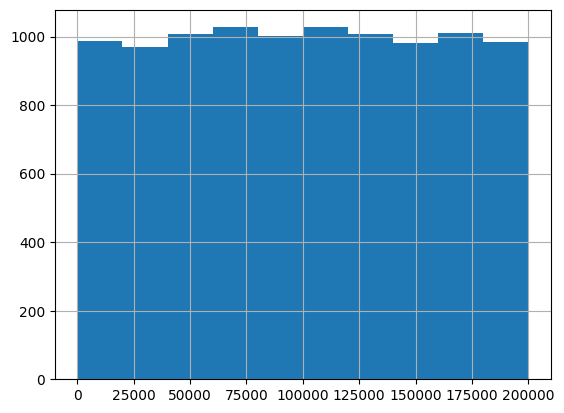

In [14]:
# histograma
df['EstimatedSalary'].hist();

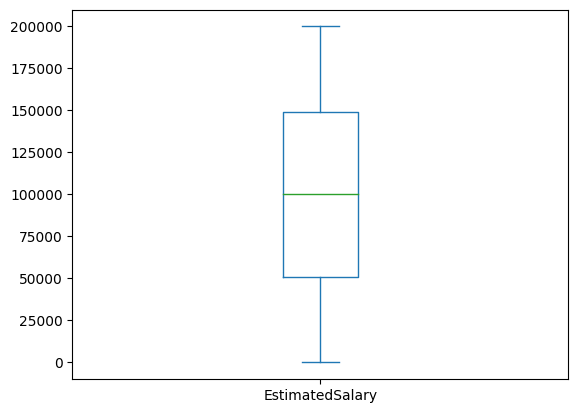

In [15]:
# boxplot
df['EstimatedSalary'].plot.box();

Observando os gráficos acima, podemos ver que a distribuição dessa variável é uniforme. Salário em geral não é uniformemente distribuído mas levando em conta que os dados são fictícios e provavelmente foram gerados de forma sintética e, por isso, vamos considerar que todos os dados estão corretos e que não há inconsistências.

Nenhuma outra variável parece apresentar nenhum comportamento estranho.

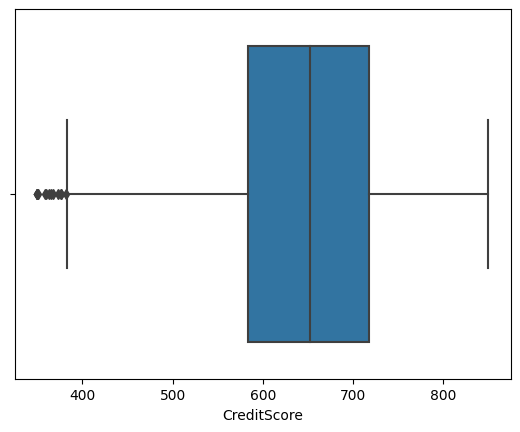

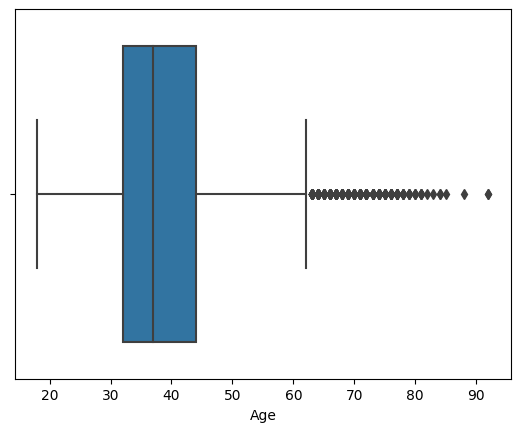

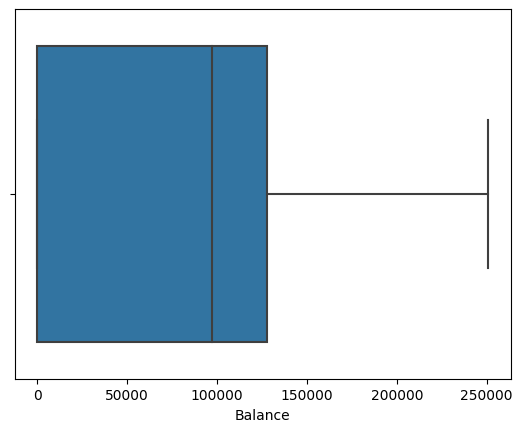

In [16]:
# boxplot para as colunas numéricas
for col in ['CreditScore','Age','Balance']:
    sns.boxplot(df, x=col)
    plt.show()

Podemos observar que alguns boxplots apontam outliers, mas já analisamos essas variáveis e todos os dados serão considerados, isto é, não iremos excluir ou tratar outliers de outra forma, pois todas essas observações são legítimas.

Entretanto, podemos ver que a variável `Age` provavelmente não tem uma distribuição simétrica, o que pode causar problemas em alguns modelos que esperam receber dados que sigam uma distribuição normal.

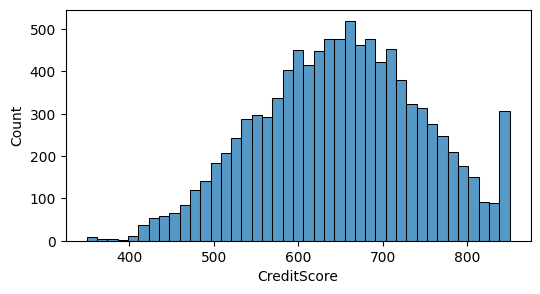

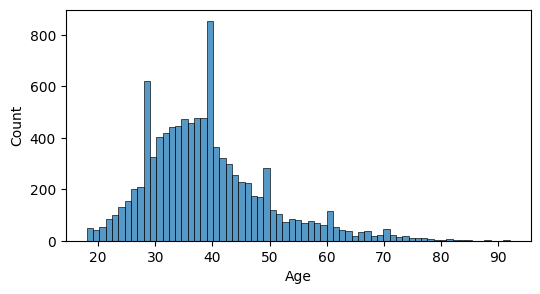

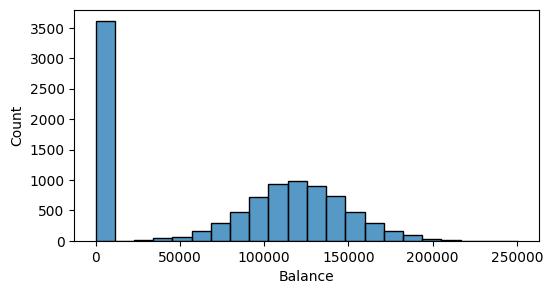

In [17]:
for col in ['CreditScore','Age','Balance']:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x=col)
    plt.show()

Observando o histograma e o boxplot para a variável `Balance`, podemos notar que há um número incomum de valores 0. Esses valores podem indicar dados faltantes que foram preenchidos com 0 ou contas que nunca foram utilizadas.

Isto sugere que consideremos uma nova variável com base nesse comportamento, em que poderíamos considerar 1 se o `Balance` for positivo e 0 se for nulo. Neste momento não temos como dizer se a criação de tal variável em detrimento da variável `Balance` atual seria interessante, por isso vamos continuar nossa análise exploratória de dados para ver se essa variável `Balance` é diferente para diferentes grupos, dando indícios de que deve ou não ser substituída.

## Análise Exploratória de Dados (Bivariada)

A seguir, vamos observar como é a distribuição de cada variável em relação à variável `Exited`.

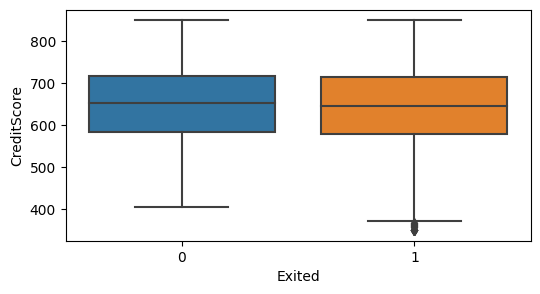

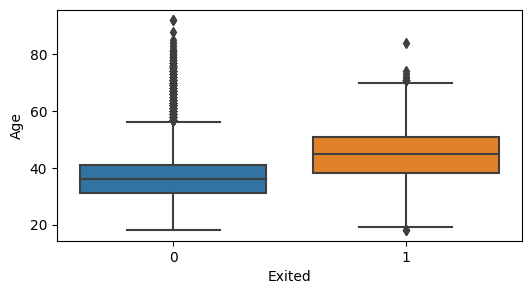

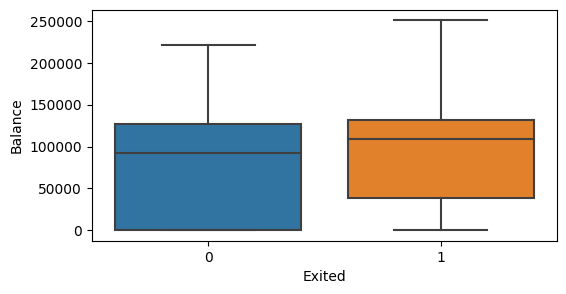

In [18]:
for col in ['CreditScore','Age','Balance']:
    plt.figure(figsize=(6,3))
    sns.boxplot(df, x='Exited', y=col)
    plt.show()

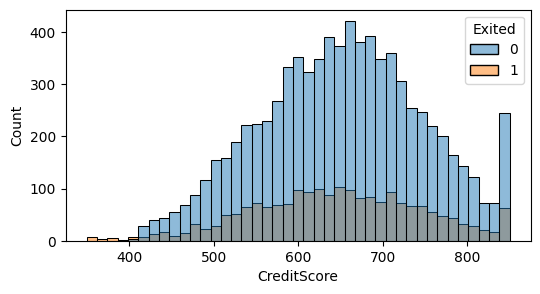

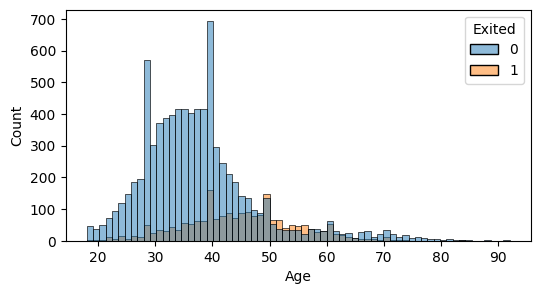

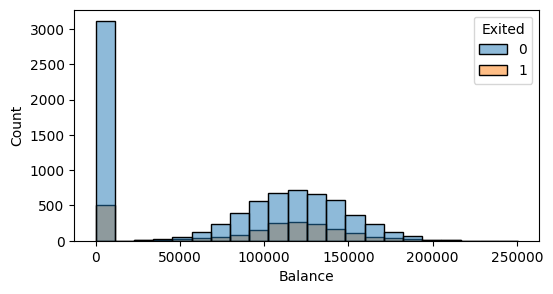

In [19]:
for col in ['CreditScore','Age','Balance']:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x = col, hue='Exited')
    plt.show()

Observando a distribuição das variáveis `Balance` e `CreditScore` por classe da variável `Exited`, podemos notar que a distribuição é essencialmente a mesma, mas há uma diferença grande no comportamento da variável `Age` por classe de `Exited`, indicando que a variável `Age` é promissora para ser usada em modelos.

Vejamos agora a distribuição de algumas variáveis por classe da variável `Geography`.

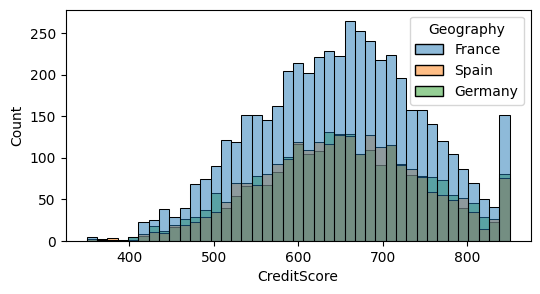

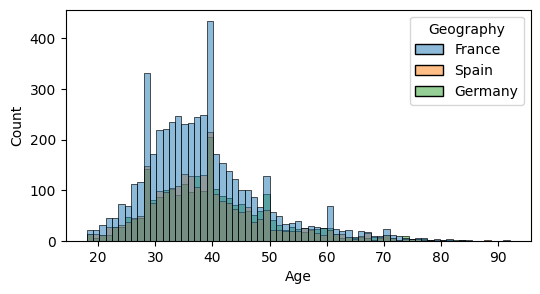

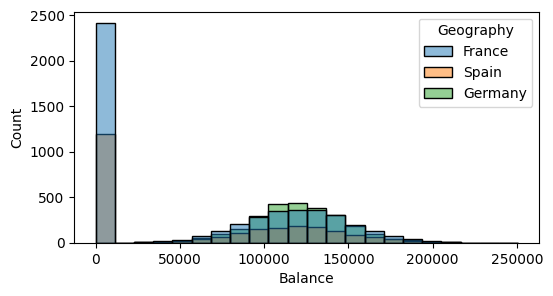

In [20]:
for col in ['CreditScore','Age','Balance']:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x = col, hue='Geography')
    plt.show()

Podemos notar que o comportamento é essencialmente o mesmo para cada país.

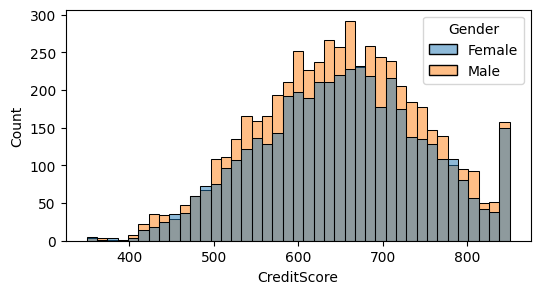

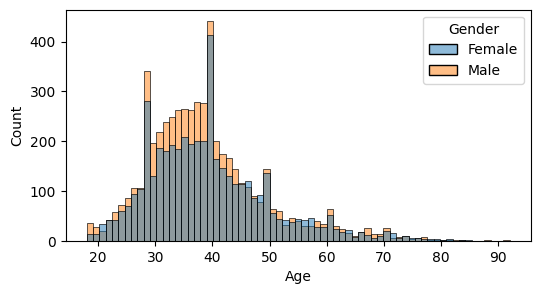

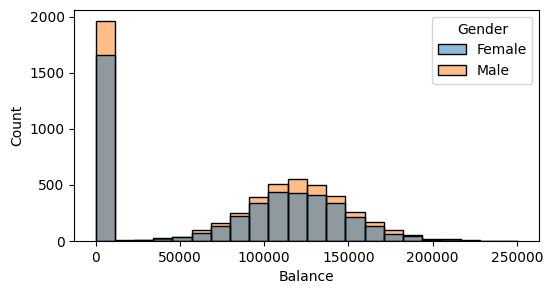

In [21]:
for col in ['CreditScore','Age','Balance']:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x = col, hue='Gender')
    plt.show()

Notamos também que o comportamento não se altera por classe da variável
`Gender`.

Com base no que vimos, a variável `Balance` tem essencialmente o mesmo comportamento para cada classe das variáveis `Exited`, `Gender` e `Geography`, portanto vamos realizar uma operação de "feature engineering" e criar uma variável categórica baseada na variável `Balance`.

In [22]:
df['Balance'] = [1 if x > 0 else 0 for x in df['Balance']]
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,101348.88,1
1,608,Spain,Female,41,1,1,1,0,1,112542.58,0
2,502,France,Female,42,8,1,3,1,0,113931.57,1
3,699,France,Female,39,1,0,2,0,0,93826.63,0
4,850,Spain,Female,43,2,1,1,1,1,79084.10,0


Vamos fazer vários gráficos parecidos, então é melhor criar algumas funções para isso.

A seguir vamos analisar as variáveis categóricas por classe da variável `Exited`.

In [23]:
# função personalizada para o countplot
def countplot_por_exited(coluna):
    plt.figure(figsize=(6,3))
    ax = sns.countplot(data=df, x=coluna, hue='Exited')
    sns.despine(left=True, bottom=True)
    for label in ax.containers:
        ax.bar_label(label)

* Vejamos a distribuição da variável `Geography` por cada classe de `Exited`.

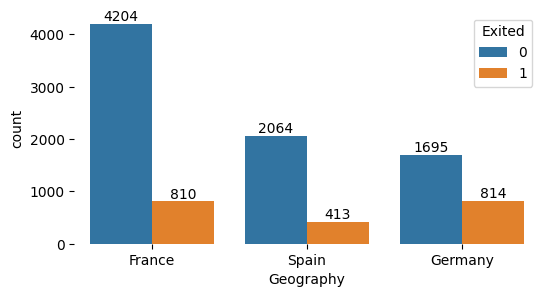

In [24]:
countplot_por_exited('Geography')

Analisando a distribuição da variável `Geography` por classe da variável `Exited`, podemos perceber que a quantidade cliente que deixam o banco é maior na "Germany" (Alemanha) do que nos demais países. Vejamos isso de maneira mais clara a seguir, onde iremos calcular o percentual de cada classe por país.

In [25]:
# tabela de contingência percentual por país
pd.crosstab(df['Geography'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
Geography,,
France,0.838452,0.161548
Germany,0.675568,0.324432
Spain,0.833266,0.166734


Podemos notar que de fato, cerca de 32% do cliente de "Germany" deixaram o banco, enquanto esse percentual é de cerca de 16% nos demais países. Isso poderia sugerir que fosse feita uma análise dos serviços e condições oferecidos na "Spain" e ofertado para os clientes de "Germany" caso faça sentido.

* Vejamos a distribuição da variável `Gender` por cada classe de `Exited`.

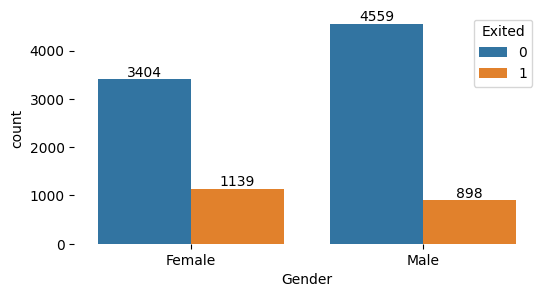

In [26]:
countplot_por_exited('Gender')

In [27]:
# tabela de contingência percentual por sexo
pd.crosstab(df['Gender'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
Gender,,
Female,0.749285,0.250715
Male,0.835441,0.164559


O gráfico sugere que mais mulheres deixaram o banco em comparação aos homens, o que poderia sugerir a criação de uma campanha ou produto que agradasse mais esse público.

* Vejamos a distribuição da variável `Tenure` por cada classe de `Exited`.

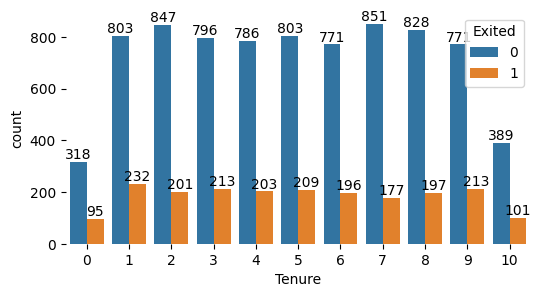

In [28]:
countplot_por_exited('Tenure')

O gráfico torna a análise mais difícil nesse caso pois são muitas categorias, vejamos uma descrição numérica.

In [29]:
# tabela de contingência percentual por tenure
pd.crosstab(df['Tenure'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
Tenure,,
0,0.769976,0.230024
1,0.775845,0.224155
2,0.808206,0.191794
3,0.788900,0.211100
4,0.794742,0.205258
5,0.793478,0.206522
6,0.797311,0.202689
7,0.827821,0.172179
8,0.807805,0.192195


Os percentuais na tabela acima parece indicar que praticamente há o mesmo percentual de clientes que deixaram o banco em cada classe da variável `Tenure`, isso poderia indicar que essa não é uma variável muito relevante para ser usada nos modelos.

* Vejamos a distribuição da variável `NumOfProducts` por cada classe de `Exited`.

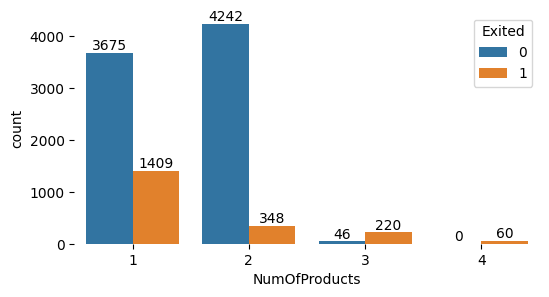

In [30]:
countplot_por_exited('NumOfProducts')

In [31]:
# tabela de contingência percentual por NumOfProducts
pd.crosstab(df['NumOfProducts'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
NumOfProducts,,
1,0.722856,0.277144
2,0.924183,0.075817
3,0.172932,0.827068
4,0.000000,1.000000


Podemos observar do gráfico que a maioria dos clientes possui 1 ou 2 produtos do banco e que a grande maioria dos clientes com mais de 2 produtos deixou o banco, embora o número total de clientes com mais de 2 produtos seja pequeno.

A menor taxa de clientes que deixam o banco aparece para aqueles que tem exatamente 2 produtos do banco. A taxa de clientes que deixam o banco também é relativamente alta para clientes que possuem apenas 1 produto e há muitos clientes nessa situação, indicando que esse é um grupo que merece atenção.

Seria interessante conhecer não apenas a quantidade de produtos que os clientes possuem mas o tipo do produto. Pode ser que os clientes que possuem 2 produtos possuem produtos específicos que são vantajosos para certo perfil como, por exemplo, jovens e solteiros, de forma que a quantidade de produtos pode não ser uma variável tão importante como o tipo do produto, mas infelizmente não temos esse dado disponível.

A sugestão seria incentivar os clientes a terem dois produtos, sendo um destes um produto específico, conforme comentado acima.

* Vejamos a distribuição da variável `HasCrCard` por cada classe de `Exited`.

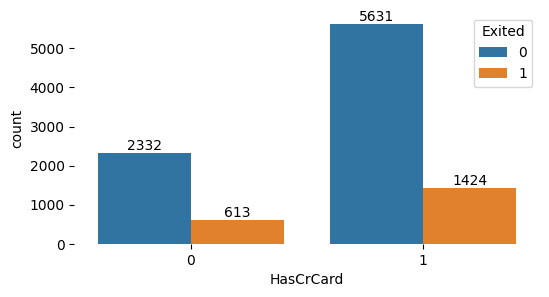

In [32]:
countplot_por_exited('HasCrCard')

In [33]:
# tabela de contingência percentual por HasCrCard
pd.crosstab(df['HasCrCard'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
HasCrCard,,
0,0.791851,0.208149
1,0.798157,0.201843


Podemos ver que o percentual de cliente que possuem ou não cartão de crédito parece não ter relação direta com o cliente deixar o banco.

* Vejamos a distribuição da variável `IsActiveMember` por cada classe de `Exited`.

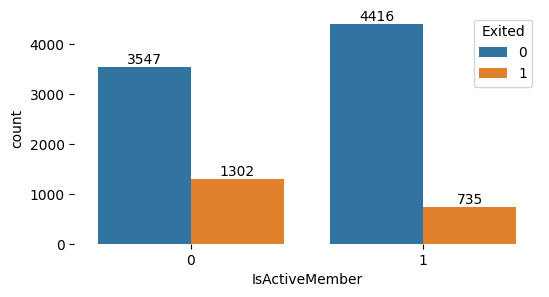

In [34]:
countplot_por_exited('IsActiveMember')

In [35]:
# tabela de contingência percentual por IsActiveMember
pd.crosstab(df['IsActiveMember'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
IsActiveMember,,
0,0.731491,0.268509
1,0.857309,0.142691


A quantidade de clientes ativos e não ativos é praticamente a mesma mas o percentual dos que deixaram o banco é muito maior em clientes não ativos, o que é esperado.

Isso sugere ações do banco para tornar o cliente mais ativo, como serviços promocionais e oferecimento de vantagens e novidades.

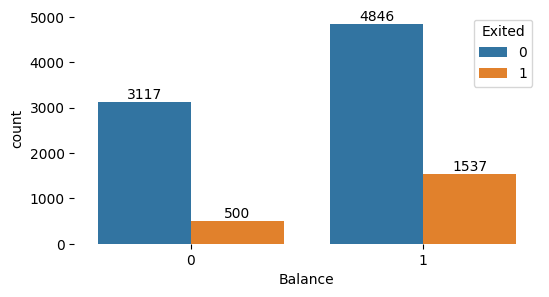

In [36]:
countplot_por_exited('Balance')

In [37]:
# tabela de contingência percentual por Balance
pd.crosstab(df['Balance'], df['Exited']).apply(lambda x: x/x.sum(), axis=1)

Exited,0,1
Balance,,
0,0.861764,0.138236
1,0.759204,0.240796


Podemos observar que o percetual de cliente que deixam o banco é maior para quem tem a variável `Balance` igual 1, ou seja, clientes que tinham originalmente `Balance` positivo.

Agora vamos analisar as variáveis categóricas por classe da variável `Geography`.

In [38]:
# função personalizada para o countplot
def countplot_por_geography(coluna):
    plt.figure(figsize=(6,3))
    ax = sns.countplot(data=df, x=coluna, hue='Geography')
    sns.despine(left=True, bottom=True)
    for label in ax.containers:
        ax.bar_label(label)

* Vejamos a distribuição da variável `Gender` por cada classe de `Geography`.

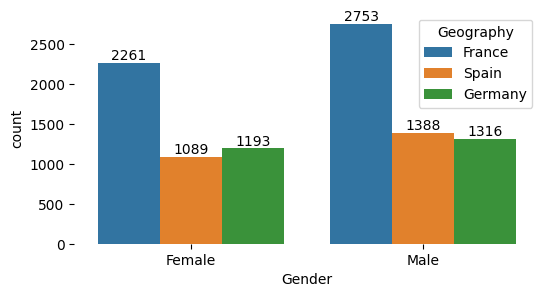

In [39]:
countplot_por_geography('Gender')

In [40]:
# tabela de contingência percentual por país
pd.crosstab(df['Gender'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
Gender,,,
Female,0.497689,0.262602,0.239709
Male,0.504490,0.241158,0.254352


O percentual de homens e mulheres é aproximadamente o mesmo para cada país.

* Vejamos a distribuição da variável `Tenure` por cada classe de `Geography`.

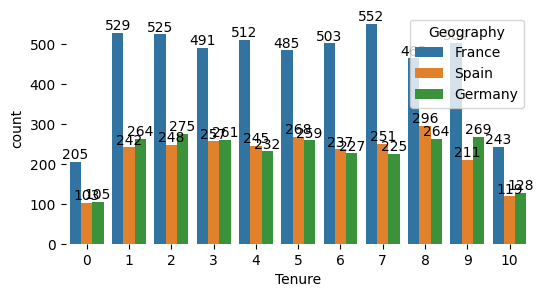

In [41]:
countplot_por_geography('Tenure')

In [42]:
# tabela de contingência percentual por país
pd.crosstab(df['Tenure'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
Tenure,,,
0,0.496368,0.254237,0.249395
1,0.511111,0.255072,0.233816
2,0.500954,0.262405,0.236641
3,0.486620,0.258672,0.254708
4,0.517695,0.234580,0.247725
5,0.479249,0.255929,0.264822
6,0.520165,0.234747,0.245088
7,0.536965,0.218872,0.244163
8,0.453659,0.257561,0.288780


O percentual de clientes para cada país, por cada categoria de `Tenure`, está de acordo com a quantidade total de clientes por categoria e país, indicando que não nada de anormal com relação à distribuição conjunta destas variáveis.

* Vejamos a distribuição da variável `NumOfProducts` por cada classe de `Geography`.

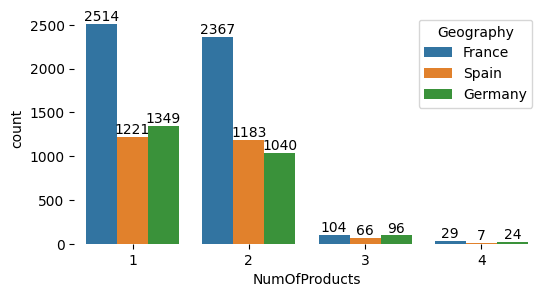

In [43]:
countplot_por_geography('NumOfProducts')

In [44]:
# tabela de contingência percentual por país
pd.crosstab(df['NumOfProducts'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
NumOfProducts,,,
1,0.494493,0.265342,0.240165
2,0.515686,0.226580,0.257734
3,0.390977,0.360902,0.248120
4,0.483333,0.400000,0.116667


As observações para a variável `NumOfProducts` em relação a `Geography` são praticamente as mesmas que foram feitas para as variável `Tenure`, embora haja uma diferença para a classe 4, mas essa classe possui poucas observações e poucos clientes tem um impacto grande no percentual.

* Vejamos a distribuição da variável `HasCrCard` por cada classe de `Geography`.

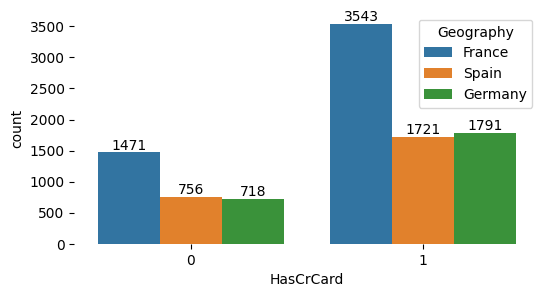

In [45]:
countplot_por_geography('HasCrCard')

In [46]:
# tabela de contingência percentual por país
pd.crosstab(df['HasCrCard'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
HasCrCard,,,
0,0.499491,0.243803,0.256706
1,0.502197,0.253863,0.243940


Os percentuais da tabela acima estão de acordo com a distribuição total de clientes por país, não indicando nada de anormal.

* Vejamos a distribuição da variável `IsActiveMember` por cada classe de `Geography`.

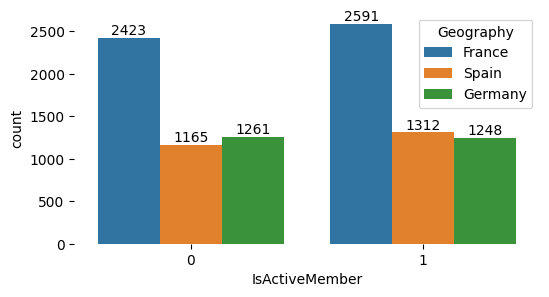

In [47]:
countplot_por_geography('IsActiveMember')

In [48]:
# tabela de contingência percentual por país
pd.crosstab(df['IsActiveMember'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
IsActiveMember,,,
0,0.499691,0.260054,0.240256
1,0.503009,0.242283,0.254708


Os percentuais da tabela acima estão de acordo com a distribuição total de clientes por país, não indicando nada de anormal.


Portanto, podemos concluir que a variável `Geography` não está influenciando algum comportamento específico de outras variáveis.

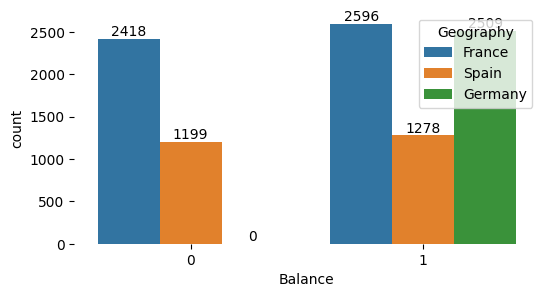

In [49]:
countplot_por_geography('Balance')

In [50]:
# tabela de contingência percentual por Balance
pd.crosstab(df['Balance'], df['Geography']).apply(lambda x: x/x.sum(), axis=1)

Geography,France,Germany,Spain
Balance,,,
0,0.668510,0.000000,0.331490
1,0.406705,0.393075,0.200219


Podemos observar que a variável `Balance` tem comportamento muito diferente dependendo do país do cliente.

Algumas das variáveis são categóricas, portanto usaremos o coeficiente de correlação de Spearman para verificar se há correlação entre as variáveis.

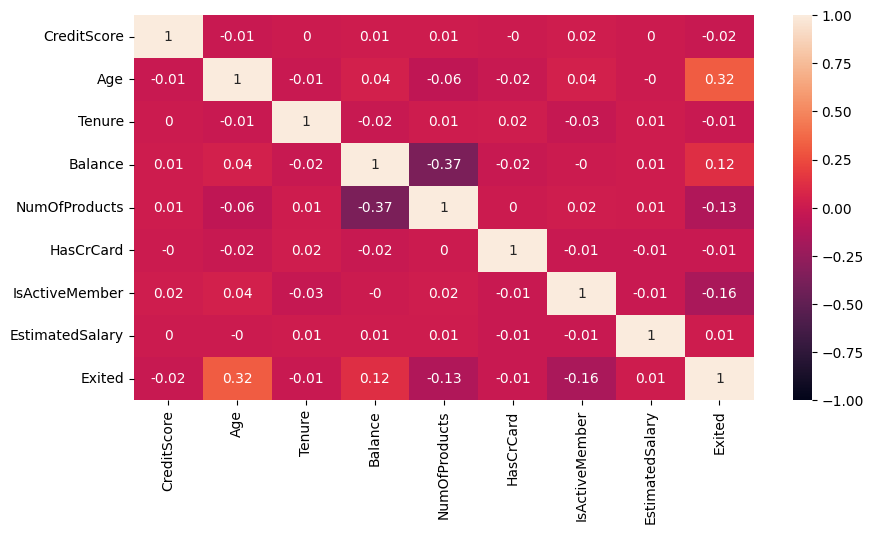

In [51]:
# calculando correlação entre as variáveis
colunas = ['CreditScore','Age','Tenure','Balance','NumOfProducts',
           'HasCrCard','IsActiveMember','EstimatedSalary','Exited']

plt.figure(figsize=(10,5))
sns.heatmap(df[colunas].corr(method='spearman').round(2), vmin=-1, vmax=1, annot=True);

Não há correlação entre as variáveis, logo não temos problemas de multicolinearidade nem forte variável candidata a desempenhar bem em algum modelo.

# Machine Learning

Antes de criar nossos modelos de classificação precisaremos tratar a variável `Exited` que está desbalanceada, colocar todos os nossos dados na mesma escala e separar em treino e teste.

A seguir vamos usar One Hot Encoding para transformar as variáveis `Geography` e `Gender` em colunas numéricas e excluir uma das colunas criadas para evitar problemas de multicolinearidade, mas primeiro precisamos instalar e importar algumas bibliotecas.

In [52]:
# importando bibliotecas
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score

### Métricas de Interesse

A seguir criaremos duas funções para nos auxiliar na avaliação dos modelos. Vamos aproveitar para definir a métrica de avaliação que usaremos neste projeto.

Neste problema a acurácia não é adequada para avaliar o problema, pois a variável alvo está desbalanceada.

Como temos um interesse que nosso modelo identifique clientes que provavelmente deixarão o banco (clientes com `Exited=1`) e estamos considerando que `1` é positivo e `0` é negativo, e levando em conta que queremos identificar o maior número possível de clientes que deixarão o banco mesmo classificando errado clientes que não deixarão banco, uma métrica de interesse é o `recall`.

O `recall` é definido por $\dfrac{VP}{VP+FN}$ em que $TP$ indica Verdadeiro Positivo e $FN$ indica Falso Negativo. Verdadeiro Positivo indica os clientes que deixaram o banco e o modelo indicou que deixariam o banco, enquanto Falso Negativo indica os clientes que deixaram o banco e o modelo indicou que não deixariam.

O `recall` é basicamente é a quantidade de verdadeiros positivos dividido pela quantidade total de positivos. Desta forma o `recall` dá um percentual dos clientes que deixaram o banco que nosso modelo conseguiu identificar corretamente.

Embora o `recall` seja a métrica principal usada nesse projeto, pois o custo de conquistar e manter um cliente novo é muito maior do que manter um cliente atual, não podemos permitir que o modelo indique que todos os clientes vão deixar o banco apenas para ter uma boa performance.

Precisamos olhar também para os Falsos Positivos, que são os clientes que o modelo indicou que deixariam o banco mas que não deixaram. Isso porque se o banco oferecer vantagens para todos os clientes a fim de mantê-los pode acabar tendo uma diminuição do lucro.

Dessa forma, olharemos também para o `precision` que é definido por $\dfrac{TP}{TP+FP}$, isto é, o `precision` é o total de verdadeiro positivos dividido pelo total de positivos indicado pelo modelo.

Como queremos obter bons valores de `recall` e `precision` somos levados naturalmente ao `f1_score` que é a média harmônica entre estas duas.


Também olharemos para a área sob a curva ROC para ter um outro parâmetro.


Sendo assim, consideraremos apenas `f1_score` e a área sob a curva ROC.

In [53]:
# Função pra criar a matriz de confusão
def matriz_confusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    fig.suptitle('Matriz de Confusão', y=1.1)
    # criando mapa de calor com valores absolutos
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Valores Preditos')
    ax1.set_ylabel('Valores Observados')

    # criando mapa de calor com valores relativos
    sns.heatmap(matriz / np.sum(matriz), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
    ax2.set_xlabel('Valores Preditos')
    ax2.set_ylabel('Valores Observados')
    fig.tight_layout()

In [55]:
# Função para criar a curva ROC e calcular a área abaixo da curva
def curva_roc(y_test, y_pred, modelo):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_val)[:,1])
    plt.figure(figsize=(4,2))
    plt.plot(fpr, tpr, label=f'(área = {round(logit_roc_auc, 2)})')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right");

One hot Encoding

In [56]:
df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348.88,1,0,0,0
1,608,41,1,1,1,0,1,112542.58,0,0,1,0
2,502,42,8,1,3,1,0,113931.57,1,0,0,0
3,699,39,1,0,2,0,0,93826.63,0,0,0,0
4,850,43,2,1,1,1,1,79084.10,0,0,1,0


Vamos separar os dados em treino e validação.

In [57]:
# separando os dados em treino e teste
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

colunas = X_train.columns

Os dados estão em escalas muito distintas e isso pode afetar alguns modelos que esperam receber os dados na mesma escala, portanto vamos mudar a escala dos valores.

Muitas das nossas variáveis assumem valores dentro de uma faixa pré fixada de valores como, por exemplo, `CreditScore` e muitas são categóricas, portanto usaremos o `MinMaxScaler` para mudar a escala dos dados.

In [58]:
# escalonando os dados
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=colunas)
X_val = pd.DataFrame(scaler.transform(X_val), columns=colunas)

In [59]:
# veerificando se a escala mudou
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.490,0.027027,0.4,1.0,0.000000,1.0,0.0,0.888722,0.0,0.0,1.0
1,0.678,0.608108,0.1,0.0,0.333333,1.0,1.0,0.932662,0.0,1.0,0.0
2,0.928,0.175676,0.1,1.0,0.000000,1.0,0.0,0.508512,0.0,0.0,1.0
3,0.744,0.027027,0.6,0.0,0.333333,1.0,0.0,0.977467,0.0,0.0,1.0
4,0.776,0.000000,0.4,0.0,0.333333,1.0,1.0,0.238961,0.0,0.0,1.0


## Machine Learning com Dados Desbalaceados

* Logistic Regression

Nosso primeiro modelo será a regressão logística, por ser um modelo simples e rápido e que poderemos usar de base em comparação com outros modelos. Usaremos o hiperparâmetros `class_weight='balanced'` pois a variável `Exited` é desbalanceada.


Usaremos também `RandomizedSearchCV` para fazer o tuning de hiperparâmetros e usar cross validation.

Como teremos várias versões do mesmo modelo, é interessante criar uma função que auxilie nessa tarefa.

In [60]:
# funcao personalizada para criar uma regressao logistica e procurar os melhores hiperparâmetros
def logistic_regression(X_train, y_train):
    # instanciando algoritmo
    model = LogisticRegression(class_weight='balanced', random_state=42)

    # criando valores para os hiperparametros
    params = {'penalty':['l2', None],
              'C':[1.5,1,0.5,0.01]}

    search = RandomizedSearchCV(model, params, cv=5, random_state=42, scoring=['f1'], refit='f1')
    search.fit(X_train, y_train)

    return search.best_estimator_

In [61]:
clf1 = logistic_regression(X_train, y_train)

# fazendo previões
y_pred1 = clf1.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:

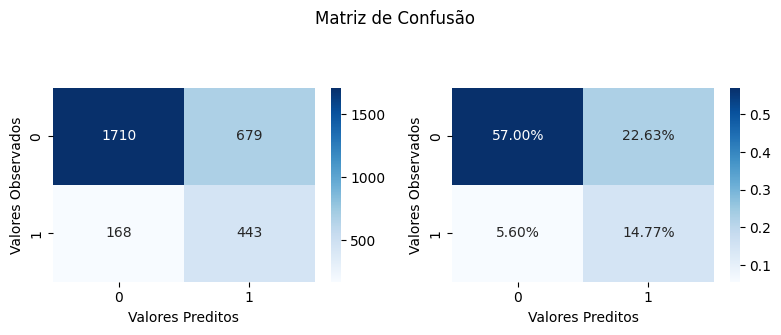

In [62]:
# criando mapa de calor
matriz_confusao(y_val, y_pred1)

Embora o número de Falsos Negativos esteja relativamente baixo (168), o número de Falsos Positivos está alto (679).

In [63]:
f1_score_1 = round(f1_score(y_val, y_pred1), 2)
logit_roc_auc_1 = round(roc_auc_score(y_val, y_pred1), 2)
print(f'f1_score = {f1_score_1}')
print(f'roc_auc = {logit_roc_auc_1}')

f1_score = 0.51
roc_auc = 0.72


Podemos observar as métricas em cada classe com a função `classification_report()`

In [64]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      2389
           1       0.39      0.73      0.51       611

    accuracy                           0.72      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.81      0.72      0.74      3000



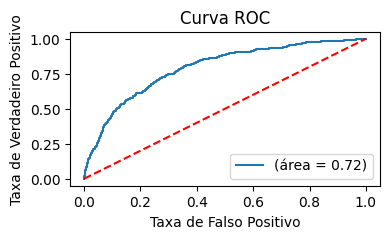

In [65]:
# curva ROC
curva_roc(y_val, y_pred1, clf1)

Este primeiro modelo servirá de baseline para as comparações que faremos a seguir, pois é rápido de treinar, tem alguma interpretabilidade, e tem um valor razoável das métricas de interesse, embora a quantidade de falsos positivos esteja alta.

* Random Forest

In [66]:
def random_forest(X_train, y_train):
    # instanciando algoritmo
    model = RandomForestClassifier(class_weight='balanced', random_state=42)

    # criando valores para os hiperparametros
    params = {'n_estimators':[5,10,25,50,100],
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features':['sqrt', 'log2'],
            'max_depth':[3,4,5,6,7,8]}

    search = RandomizedSearchCV(model, params, cv=5, random_state=42, scoring=['f1'], refit='f1')
    search.fit(X_train, y_train)

    return search.best_estimator_

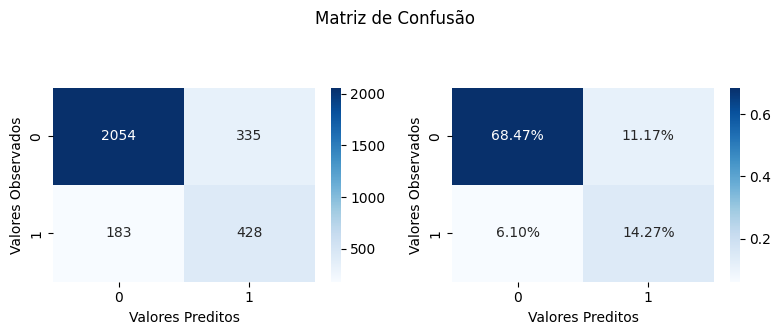

In [67]:
clf2 = random_forest(X_train, y_train)

# fazendo previsões no conjunto de teste
y_pred2 = clf2.predict(X_val)

# criando mapa de calor
matriz_confusao(y_val, y_pred2)

In [68]:
f1_score_2 = round(f1_score(y_val, y_pred2), 2)
logit_roc_auc_2 = round(roc_auc_score(y_val, y_pred2), 2)
print(f'f1_score = {f1_score_2}')
print(f'roc_auc = {logit_roc_auc_2}')

f1_score = 0.62
roc_auc = 0.78


In [69]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2389
           1       0.56      0.70      0.62       611

    accuracy                           0.83      3000
   macro avg       0.74      0.78      0.76      3000
weighted avg       0.85      0.83      0.83      3000



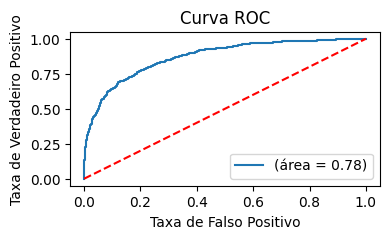

In [70]:
curva_roc(y_val, y_pred2, clf2)

Em comparação com o primeiro modelo podemos notar que a quantidade de falsos negativos não mudou muito, mas houve uma diminuição considerável dos falsos positivos, indicado que este modelo está melhor.

* XGBoost

In [71]:
def meu_xgboost(X_train, y_train):
    # instanciando modelo
    model = XGBClassifier(eval_metric='logloss', random_state=42)

    # criando hiperparâmetros
    params = {'n_estimators':[5,10,25,50,100],
            'max_depth':[3,4,5,6,7,8]}

    search = RandomizedSearchCV(model, params, cv=5, random_state=42, scoring=['f1'], refit='f1')
    search.fit(X_train, y_train)

    return search.best_estimator_

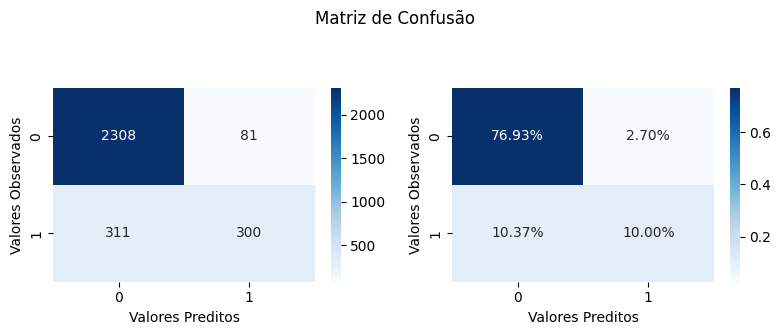

In [72]:
clf3 = meu_xgboost(X_train, y_train)

# fazendo previsões no conjunto de teste
y_pred3 = clf3.predict(X_val)

# criando mapa de calor
matriz_confusao(y_val, y_pred3)

In [73]:
f1_score_3 = round(f1_score(y_val, y_pred3), 2)
logit_roc_auc_3 = round(roc_auc_score(y_val, y_pred3), 2)
print(f'f1_score = {f1_score_3}')
print(f'roc_auc = {logit_roc_auc_3}')

f1_score = 0.6
roc_auc = 0.73


In [74]:
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.79      0.49      0.60       611

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



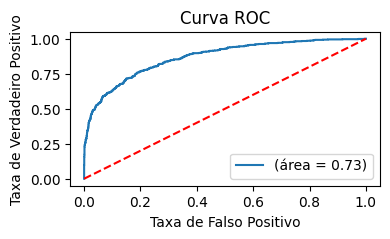

In [75]:
curva_roc(y_val, y_pred3, clf3)

Comparado com o Random Forest, o XGBoost apresentou um aumento grande de falsos negativos e uma grande diminuição de falsos positivos, indicando que não está adequado.

* Rede Neural

Criaremos uma rede neural com `Keras` e usaremos a biblioteca `Optuna` para encontrar o melhor conjunto de hiperparâmetros.

In [76]:
# instalando bibliotecas
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [77]:
# importando layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import PrecisionAtRecall, Recall
from keras.callbacks import EarlyStopping
import optuna

Vamos criar duas funções para acompanhar a acurácia e a função de perda no conjunto de treino e de validação.

In [78]:
# funcao para acompanhar a acuracia
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');

In [79]:
# funcao para acompanhar a função de perda
def plot_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [80]:
# Definir a função objetivo para otimização
def objective(trial):
    # Definir os hiperparâmetros a serem otimizados
    hidden_units = trial.suggest_int('hidden_units', 2, 20)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    epochs = trial.suggest_int('epochs', 20, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.9)

    # Construir o modelo da rede neural
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=11, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Fazer previsões nos dados de teste
    y_pred = (model.predict(X_val) >= 0.5).astype(int)

    # Calcular o f1-score
    f_score = f1_score(y_val, y_pred)

    return f_score

In [81]:
# Criar um estudo Optuna e otimizar os hiperparâmetros
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective, n_trials=15)

# Imprimir os resultados
print("Melhores Hiperparâmetros: {}".format(study4.best_trial.params))

[I 2023-06-14 03:30:25,827] A new study created in memory with name: no-name-b1ebaca8-9ef5-4f00-bd2f-fde0ecbe529c


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:31:52,575] Trial 0 finished with value: 0.5809128630705394 and parameters: {'hidden_units': 15, 'optimizer': 'adam', 'epochs': 89, 'dropout_rate': 0.14804460009657278}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 1s 5ms/step


[I 2023-06-14 03:32:35,150] Trial 1 finished with value: 0.4876325088339223 and parameters: {'hidden_units': 19, 'optimizer': 'rmsprop', 'epochs': 52, 'dropout_rate': 0.6376220693909519}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:33:38,613] Trial 2 finished with value: 0.5499462943071965 and parameters: {'hidden_units': 15, 'optimizer': 'rmsprop', 'epochs': 94, 'dropout_rate': 0.500049691912258}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:33:55,749] Trial 3 finished with value: 0.48703494926719276 and parameters: {'hidden_units': 9, 'optimizer': 'rmsprop', 'epochs': 26, 'dropout_rate': 0.2582739242788355}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:34:44,102] Trial 4 finished with value: 0.3324468085106383 and parameters: {'hidden_units': 15, 'optimizer': 'rmsprop', 'epochs': 75, 'dropout_rate': 0.8151920113077957}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:35:25,979] Trial 5 finished with value: 0.548728813559322 and parameters: {'hidden_units': 20, 'optimizer': 'rmsprop', 'epochs': 67, 'dropout_rate': 0.5722552727141358}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:36:26,899] Trial 6 finished with value: 0.5609492988133765 and parameters: {'hidden_units': 13, 'optimizer': 'rmsprop', 'epochs': 96, 'dropout_rate': 0.22908685042704793}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:37:13,114] Trial 7 finished with value: 0.4617142857142857 and parameters: {'hidden_units': 8, 'optimizer': 'rmsprop', 'epochs': 73, 'dropout_rate': 0.32847459541664004}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:38:01,612] Trial 8 finished with value: 0.5017421602787456 and parameters: {'hidden_units': 13, 'optimizer': 'adam', 'epochs': 74, 'dropout_rate': 0.4178040201546943}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:38:53,387] Trial 9 finished with value: 0.36141636141636146 and parameters: {'hidden_units': 4, 'optimizer': 'rmsprop', 'epochs': 69, 'dropout_rate': 0.38456277055731414}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:39:14,848] Trial 10 finished with value: 0.0 and parameters: {'hidden_units': 3, 'optimizer': 'adam', 'epochs': 11, 'dropout_rate': 0.16765929458679735}. Best is trial 0 with value: 0.5809128630705394.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:40:25,688] Trial 11 finished with value: 0.6031434184675836 and parameters: {'hidden_units': 12, 'optimizer': 'adam', 'epochs': 99, 'dropout_rate': 0.12251724124849195}. Best is trial 11 with value: 0.6031434184675836.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:41:31,626] Trial 12 finished with value: 0.5819672131147542 and parameters: {'hidden_units': 17, 'optimizer': 'adam', 'epochs': 100, 'dropout_rate': 0.10165292582356317}. Best is trial 11 with value: 0.6031434184675836.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:42:02,930] Trial 13 finished with value: 0.5385450597176983 and parameters: {'hidden_units': 18, 'optimizer': 'adam', 'epochs': 45, 'dropout_rate': 0.10692346437304592}. Best is trial 11 with value: 0.6031434184675836.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:43:25,972] Trial 14 finished with value: 0.6068702290076335 and parameters: {'hidden_units': 10, 'optimizer': 'adam', 'epochs': 84, 'dropout_rate': 0.10115157382583935}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:44:48,866] Trial 15 finished with value: 0.5405405405405406 and parameters: {'hidden_units': 7, 'optimizer': 'adam', 'epochs': 84, 'dropout_rate': 0.2652199545136441}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:46:11,920] Trial 16 finished with value: 0.5702393340270551 and parameters: {'hidden_units': 11, 'optimizer': 'adam', 'epochs': 84, 'dropout_rate': 0.2008994078016776}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:46:50,223] Trial 17 finished with value: 0.560344827586207 and parameters: {'hidden_units': 10, 'optimizer': 'adam', 'epochs': 58, 'dropout_rate': 0.3093013399961341}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:47:16,692] Trial 18 finished with value: 0.49281767955801103 and parameters: {'hidden_units': 6, 'optimizer': 'adam', 'epochs': 38, 'dropout_rate': 0.19384853598168938}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:48:15,054] Trial 19 finished with value: 0.5723270440251571 and parameters: {'hidden_units': 5, 'optimizer': 'adam', 'epochs': 87, 'dropout_rate': 0.13141796266613312}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:48:56,993] Trial 20 finished with value: 0.5306577480490524 and parameters: {'hidden_units': 13, 'optimizer': 'adam', 'epochs': 58, 'dropout_rate': 0.2956967885201541}. Best is trial 14 with value: 0.6068702290076335.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:50:19,875] Trial 21 finished with value: 0.6190476190476191 and parameters: {'hidden_units': 16, 'optimizer': 'adam', 'epochs': 99, 'dropout_rate': 0.10307828794126139}. Best is trial 21 with value: 0.6190476190476191.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:51:42,926] Trial 22 finished with value: 0.5656779661016949 and parameters: {'hidden_units': 12, 'optimizer': 'adam', 'epochs': 100, 'dropout_rate': 0.10397704554562036}. Best is trial 21 with value: 0.6190476190476191.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:52:37,382] Trial 23 finished with value: 0.5522388059701492 and parameters: {'hidden_units': 16, 'optimizer': 'adam', 'epochs': 80, 'dropout_rate': 0.20043341603154596}. Best is trial 21 with value: 0.6190476190476191.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:54:00,459] Trial 24 finished with value: 0.5783619817997977 and parameters: {'hidden_units': 10, 'optimizer': 'adam', 'epochs': 92, 'dropout_rate': 0.18635846752315038}. Best is trial 21 with value: 0.6190476190476191.


Melhores Hiperparâmetros: {'hidden_units': 16, 'optimizer': 'adam', 'epochs': 99, 'dropout_rate': 0.10307828794126139}


In [82]:
# treinando a rede neural com os melhores hiperparâmetros
best_params4 = study4.best_trial.params

clf4 = Sequential()
clf4.add(Dense(best_params4['hidden_units'], input_dim=11, activation='relu'))
clf4.add(Dense(best_params4['hidden_units'], activation='relu'))
clf4.add(Dropout(best_params4['dropout_rate']))
clf4.add(Dense(1, activation='sigmoid'))
clf4.compile(loss='binary_crossentropy', optimizer=best_params4['optimizer'], metrics=['accuracy'])

# callbacks
callback = EarlyStopping(monitor='loss', patience=5, verbose=False)

# Treinar o modelo com todos os dados de treinamento
history4 = clf4.fit(X_train, y_train,
                   epochs=best_params4['epochs'],
                   callbacks=[callback],
                   validation_split = 0.20,
                   verbose=False)

# Fazer previsões com o modelo treinado
y_pred4 = (clf4.predict(X_val) >= 0.5).astype(int)

94/94 [==============================] - 0s 1ms/step


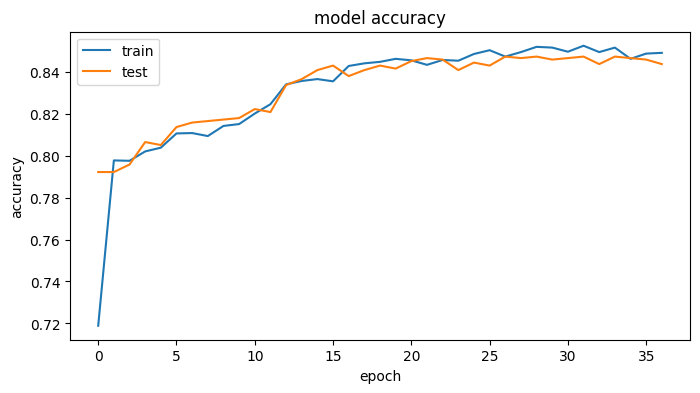

In [83]:
plot_accuracy(history4)

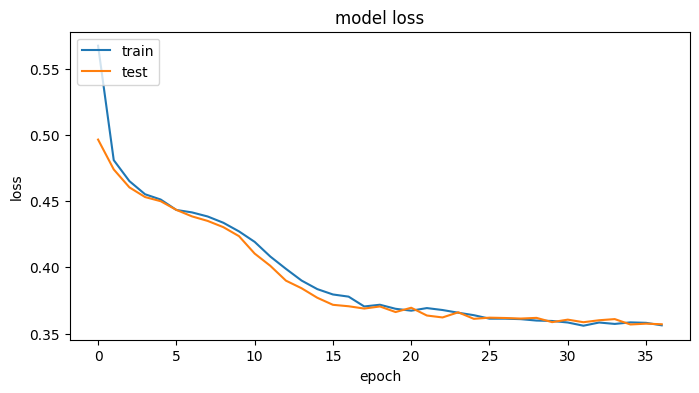

In [84]:
plot_loss(history4)

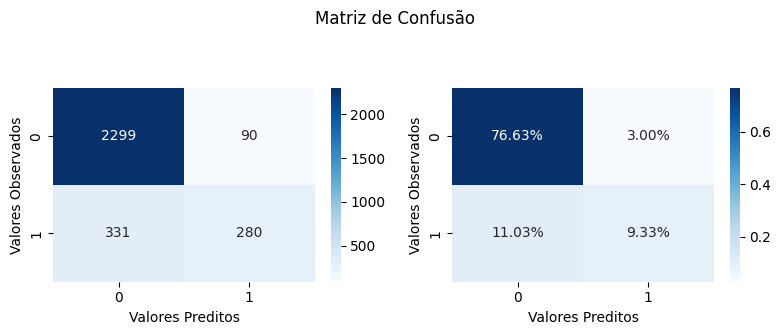

In [85]:
matriz_confusao(y_val, y_pred4)

In [86]:
f1_score_4 = round(f1_score(y_val, y_pred4), 2)
logit_roc_auc_4 = round(roc_auc_score(y_val, y_pred4), 2)
print(f'f1_score = {f1_score_4}')
print(f'roc_auc = {logit_roc_auc_4}')

f1_score = 0.57
roc_auc = 0.71


In [87]:
# observando métricas por classe
print(classification_report(y_val, y_pred4))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2389
           1       0.76      0.46      0.57       611

    accuracy                           0.86      3000
   macro avg       0.82      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



94/94 [==============================] - 0s 2ms/step


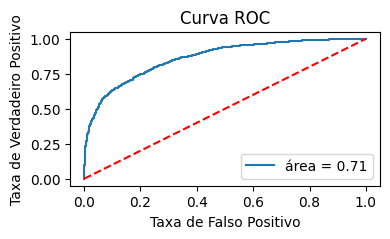

In [88]:
# curva ROC
logit_roc_auc = roc_auc_score(y_val, y_pred4)
fpr, tpr, thresholds = roc_curve(y_val, clf4.predict(X_val))
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, label=f'área = {round(logit_roc_auc, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

A rede neural apresentou o mesmo problema do XGBoost.

* AutoML com CatBoost

Usaremos a biblioteca `CatBoost` para aplicar AutoML e ver se algum modelo interessante aparece.

In [89]:
# instalando biblioteca
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.2 MB/s eta 0:00:00


In [90]:
from catboost import CatBoostClassifier

In [91]:
def automl(X_train, y_train):
    # features categóricas
    cat_features = [2,3,4,5,6,8,9,10]

    # alvo
    embedding_features=[0, 1]

    # grid de hiperparâmetros
    grid = {'learning_rate': [1, 0.1, 0.01],
    'depth': [4, 6, 10, 15, 20],
    'l2_leaf_reg': [3, 5],
    'iterations': [5, 20, 40]}

    # instanciando CatBoostClassifier
    model = CatBoostClassifier(iterations=5,
                            learning_rate=0.1,
                            depth=10,
                            random_state=42,
                            loss_function='Logloss',
                            eval_metric='F1')

    # otimização dos hiperparâmetros
    model.grid_search(grid, X_train, y_train, cv=3, partition_random_seed=42, verbose=False)

    # melhores hiperparâmetros
    best_params = model.get_params()

    # Criar e treinar o modelo CatBoost com os melhores hiperparâmetros
    model = CatBoostClassifier(**best_params)
    model.fit(X_train, y_train, verbose=False)

    return model

In [92]:
clf5 = automl(X_train, y_train)

# fazendo previsão
y_pred5 = clf5.predict(X_val)

0:	learn: 0.5277207	test: 0.4943311	best: 0.4943311 (0)	total: 48.6ms	remaining: 195ms
1:	learn: 0.5604167	test: 0.5355450	best: 0.5355450 (1)	total: 50.9ms	remaining: 76.4ms
2:	learn: 0.5814536	test: 0.5590909	best: 0.5590909 (2)	total: 52.9ms	remaining: 35.2ms
3:	learn: 0.5727898	test: 0.5454545	best: 0.5590909 (2)	total: 54.8ms	remaining: 13.7ms
4:	learn: 0.5804416	test: 0.5489260	best: 0.5590909 (2)	total: 56.8ms	remaining: 0us

bestTest = 0.5590909091
bestIteration = 2

0:	learn: 0.5277207	test: 0.4943311	best: 0.4943311 (0)	total: 1.96ms	remaining: 7.84ms
1:	learn: 0.5122090	test: 0.4754522	best: 0.4943311 (0)	total: 3.89ms	remaining: 5.83ms
2:	learn: 0.5301339	test: 0.4987531	best: 0.4987531 (2)	total: 5.76ms	remaining: 3.84ms
3:	learn: 0.5122090	test: 0.4754522	best: 0.4987531 (2)	total: 7.77ms	remaining: 1.94ms
4:	learn: 0.4908121	test: 0.4690027	best: 0.4987531 (2)	total: 9.95ms	remaining: 0us

bestTest = 0.4987531172
bestIteration = 2

0:	learn: 0.5277207	test: 0.4943311	bes

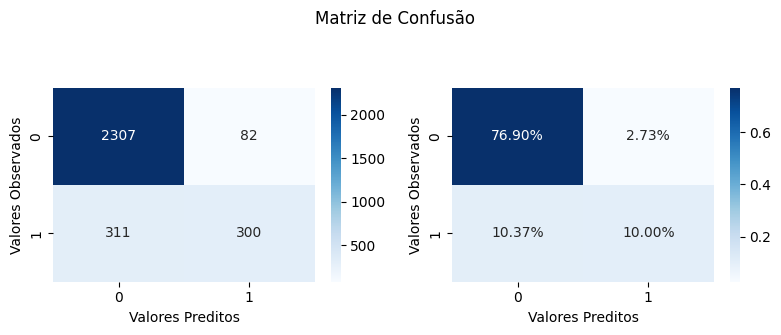

In [93]:
matriz_confusao(y_val, y_pred5)

In [94]:
f1_score_5 = round(f1_score(y_val, y_pred5), 2)
logit_roc_auc_5 = round(roc_auc_score(y_val, y_pred5), 2)
print(f'f1_score = {f1_score_5}')
print(f'roc_auc = {logit_roc_auc_5}')

f1_score = 0.6
roc_auc = 0.73


In [95]:
print(classification_report(y_val, y_pred5))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.79      0.49      0.60       611

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



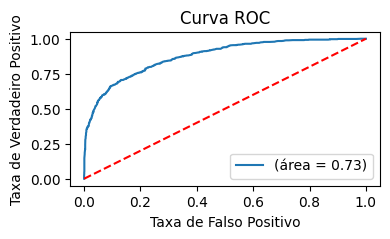

In [96]:
curva_roc(y_val, y_pred5, clf5)

O modelo encontrado por AutoML apresenta o mesmo problema do XGBoost e da Rede Neural.

## Machine Learning com Dados Balanceados via Undersampling

Agora vamos balancear os dados usando uma técnica chamada undersampling, que vai descartar observações da classe maior até que o tamanho das duas classes fique igual. Após isso vamos treinar novos modelos.

In [97]:
# criando dados sintéticos para balancear as classes y
from imblearn.under_sampling import RandomUnderSampler
ROS = RandomUnderSampler(sampling_strategy='majority')
X_train2, y_train2 = ROS.fit_resample(X_train, y_train)

* Logistic Regression

In [98]:
clf6 = logistic_regression(X_train2, y_train2)

# fazendo previsões
y_pred6 = clf6.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:

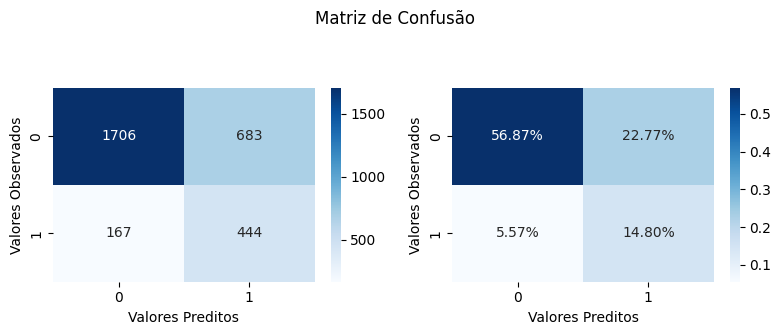

In [99]:
# criando matriz de confusão
matriz_confusao(y_val, y_pred6)

In [100]:
f1_score_6 = round(f1_score(y_val, y_pred6), 2)
logit_roc_auc_6 = round(roc_auc_score(y_val, y_pred6), 2)
print(f'f1_score = {f1_score_6}')
print(f'roc_auc = {logit_roc_auc_6}')

f1_score = 0.51
roc_auc = 0.72


In [101]:
print(classification_report(y_val, y_pred6))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2389
           1       0.39      0.73      0.51       611

    accuracy                           0.72      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.81      0.72      0.74      3000



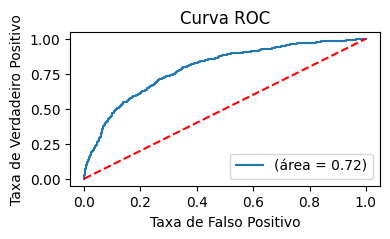

In [102]:
curva_roc(y_val, y_pred6, clf6)

Utilizar undersampling praticamente não teve nenhum efeito se comparado com a primeira versão da regressão logística.

* Random Forest

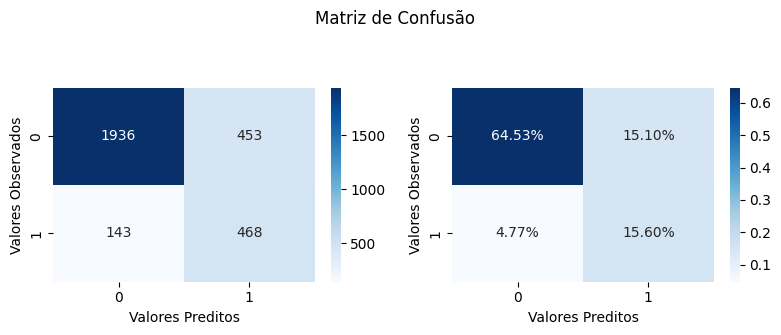

In [103]:
# treinando modelo
clf7 = random_forest(X_train2, y_train2)

# fazendo previsões
y_pred7 = clf7.predict(X_val)

# matriz de confusão
matriz_confusao(y_val, y_pred7)

In [104]:
f1_score_7 = round(f1_score(y_val, y_pred7), 2)
logit_roc_auc_7 = round(roc_auc_score(y_val, y_pred7), 2)
print(f'f1_score = {f1_score_7}')
print(f'roc_auc = {logit_roc_auc_7}')

f1_score = 0.61
roc_auc = 0.79


In [105]:
print(classification_report(y_val, y_pred7))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2389
           1       0.51      0.77      0.61       611

    accuracy                           0.80      3000
   macro avg       0.72      0.79      0.74      3000
weighted avg       0.85      0.80      0.81      3000



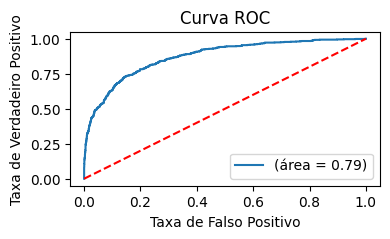

In [106]:
curva_roc(y_val, y_pred7, clf7)

Essa versão do Random Forest com undersampling está melhor que a versão anterior e é o melhor modelo obtido até o momento, embora a diferença não seja tão grande. A diferença se deu porque houve uma pequena diminuição de falsos negativos e um pequeno aumento de falsos positivos.

Podemos olhar para a importância das variáveis para obter algum insight do que pode estar influenciando na decisão dos clientes deixarem o banco. Vamos criar uma função para isso, pois a usaremos algumas vezes.

In [107]:
def importancia_variaveis(clf):
    # calculando a importância das variáveis
    result = permutation_importance(
        clf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2, scoring='f1'
    )

    sorted_importances_idx = result['importances_mean'].argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )

    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Importância das Permutações em Validação")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decaimento no f1")
    ax.figure.tight_layout()

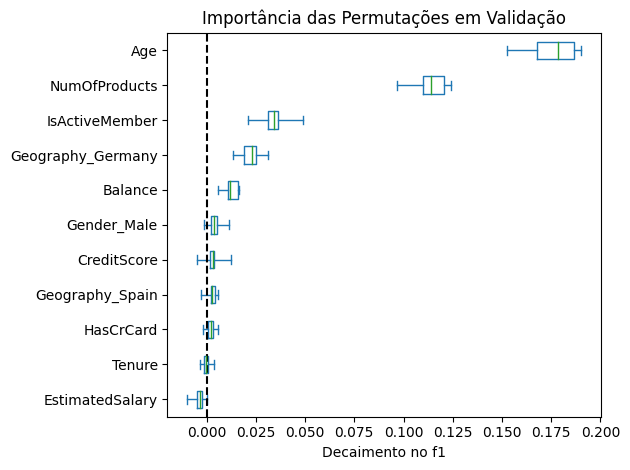

In [108]:
importancia_variaveis(clf7)

Analisando o gráfico podemos ver que algumas variáveis tem relevância, estas são: `Age`, `NumOfProducts`, `Geography_Germany`, `Gender_Male` e `IsActiveMember`. Todas essas variáveis foram apontadas como promissoras na análise exploratória de dados, confirmando parte das suspeitar levantadas naquelas análise.

* XGBoost

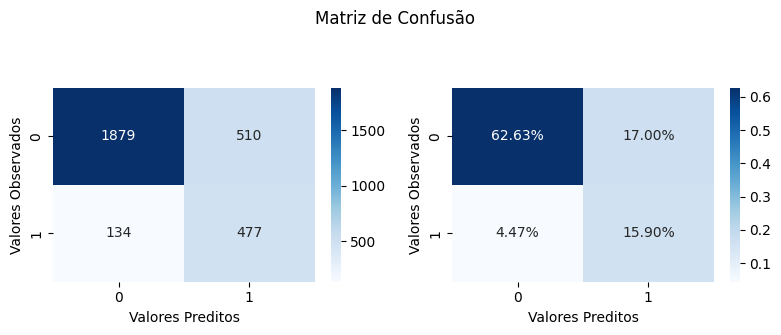

In [109]:
clf8 = meu_xgboost(X_train2, y_train2)

# fazendo previsões no conjunto de teste
y_pred8 = clf8.predict(X_val)

# criando mapa de calor
matriz_confusao(y_val, y_pred8)

In [110]:
f1_score_8 = round(f1_score(y_val, y_pred8), 2)
logit_roc_auc_8 = round(roc_auc_score(y_val, y_pred8), 2)
print(f'f1_score = {f1_score_8}')
print(f'roc_auc = {logit_roc_auc_8}')

f1_score = 0.6
roc_auc = 0.78


In [111]:
print(classification_report(y_val, y_pred8))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      2389
           1       0.48      0.78      0.60       611

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.79      0.80      3000



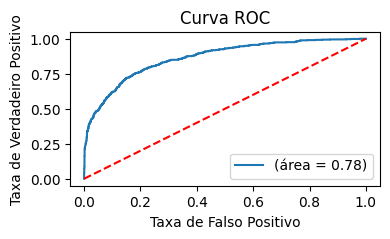

In [112]:
curva_roc(y_val, y_pred8, clf8)

Este modelo apresenta praticamente os mesmo valores da segunda versão da Random Forest que é o melhor modelo encontrado até o momento.

* Rede Neural

In [113]:
# Definir a função objetivo para otimização
def objective9(trial):
    # Definir os hiperparâmetros a serem otimizados
    hidden_units = trial.suggest_int('hidden_units', 2, 20)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    epochs = trial.suggest_int('epochs', 20, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.9)

    # Construir o modelo da rede neural
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=11, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train2, y_train2, epochs=epochs, verbose=0)

    # Fazer previsões nos dados de teste
    y_pred = (model.predict(X_val) >= 0.5).astype(int)

    # Calcular o F-score
    f_score = f1_score(y_val, y_pred)

    return f_score

In [114]:
# Criar um estudo Optuna e otimizar os hiperparâmetros
study9 = optuna.create_study(direction='maximize')
study9.optimize(objective9, n_trials=15)

# Imprimir os resultados
print("Melhores Hiperparâmetros: {}".format(study9.best_trial.params))

[I 2023-06-14 03:57:59,090] A new study created in memory with name: no-name-fe65bac5-338f-4460-80f3-26b7d067929d


94/94 [==============================] - 1s 6ms/step


[I 2023-06-14 03:58:12,259] Trial 0 finished with value: 0.5256627185561196 and parameters: {'hidden_units': 10, 'optimizer': 'rmsprop', 'epochs': 24, 'dropout_rate': 0.35023718745881216}. Best is trial 0 with value: 0.5256627185561196.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:58:27,660] Trial 1 finished with value: 0.5301866081229419 and parameters: {'hidden_units': 10, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.5507481525418911}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:58:49,264] Trial 2 finished with value: 0.4661064425770309 and parameters: {'hidden_units': 8, 'optimizer': 'adam', 'epochs': 31, 'dropout_rate': 0.801466598298238}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 03:59:00,400] Trial 3 finished with value: 0.5027624309392265 and parameters: {'hidden_units': 17, 'optimizer': 'rmsprop', 'epochs': 36, 'dropout_rate': 0.8659197366470504}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:59:12,391] Trial 4 finished with value: 0.49967886962106606 and parameters: {'hidden_units': 2, 'optimizer': 'adam', 'epochs': 38, 'dropout_rate': 0.38320264561140804}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:59:19,966] Trial 5 finished with value: 0.522207267833109 and parameters: {'hidden_units': 17, 'optimizer': 'adam', 'epochs': 21, 'dropout_rate': 0.7291580136046361}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:59:31,049] Trial 6 finished with value: 0.4318418314255983 and parameters: {'hidden_units': 3, 'optimizer': 'rmsprop', 'epochs': 23, 'dropout_rate': 0.7047833789629346}. Best is trial 1 with value: 0.5301866081229419.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 03:59:41,962] Trial 7 finished with value: 0.5590599876314162 and parameters: {'hidden_units': 17, 'optimizer': 'adam', 'epochs': 34, 'dropout_rate': 0.8184738901866394}. Best is trial 7 with value: 0.5590599876314162.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:00:03,421] Trial 8 finished with value: 0.5180442374854481 and parameters: {'hidden_units': 9, 'optimizer': 'rmsprop', 'epochs': 48, 'dropout_rate': 0.5382812944933053}. Best is trial 7 with value: 0.5590599876314162.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:00:17,571] Trial 9 finished with value: 0.565438373570521 and parameters: {'hidden_units': 10, 'optimizer': 'rmsprop', 'epochs': 48, 'dropout_rate': 0.4794853314315052}. Best is trial 9 with value: 0.565438373570521.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:00:39,306] Trial 10 finished with value: 0.5577043044291953 and parameters: {'hidden_units': 14, 'optimizer': 'rmsprop', 'epochs': 43, 'dropout_rate': 0.10743978788052083}. Best is trial 9 with value: 0.565438373570521.


94/94 [==============================] - 1s 2ms/step


[I 2023-06-14 04:00:50,397] Trial 11 finished with value: 0.5304136253041363 and parameters: {'hidden_units': 14, 'optimizer': 'adam', 'epochs': 31, 'dropout_rate': 0.6239447272488147}. Best is trial 9 with value: 0.565438373570521.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:01:04,202] Trial 12 finished with value: 0.5580276608538784 and parameters: {'hidden_units': 20, 'optimizer': 'adam', 'epochs': 42, 'dropout_rate': 0.8423338193930283}. Best is trial 9 with value: 0.565438373570521.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:01:14,534] Trial 13 finished with value: 0.46188340807174894 and parameters: {'hidden_units': 6, 'optimizer': 'adam', 'epochs': 30, 'dropout_rate': 0.6914574078397452}. Best is trial 9 with value: 0.565438373570521.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:01:28,038] Trial 14 finished with value: 0.5712523133867983 and parameters: {'hidden_units': 13, 'optimizer': 'rmsprop', 'epochs': 44, 'dropout_rate': 0.4658503519769123}. Best is trial 14 with value: 0.5712523133867983.


Melhores Hiperparâmetros: {'hidden_units': 13, 'optimizer': 'rmsprop', 'epochs': 44, 'dropout_rate': 0.4658503519769123}


In [115]:
# treinando a rede neural com os melhores hiperparâmetros
best_params9 = study9.best_trial.params

clf9 = Sequential()
clf9.add(Dense(best_params9['hidden_units'], input_dim=11, activation='relu'))
clf9.add(Dense(best_params9['hidden_units'], activation='relu'))
clf9.add(Dropout(best_params9['dropout_rate']))
clf9.add(Dense(1, activation='sigmoid'))
clf9.compile(loss='binary_crossentropy', optimizer=best_params9['optimizer'], metrics=['accuracy'])

# callbacks
callback = EarlyStopping(monitor='loss', patience=5, verbose=False)

# Treinar o modelo com todos os dados de treinamento
history9 = clf9.fit(X_train2, y_train2,
                   epochs=best_params9['epochs'],
                   callbacks=[callback],
                   validation_split = 0.20,
                   verbose=False)

# Fazer previsões com o modelo treinado
y_pred9 = (clf9.predict(X_val) >= 0.5).astype(int)

94/94 [==============================] - 0s 1ms/step


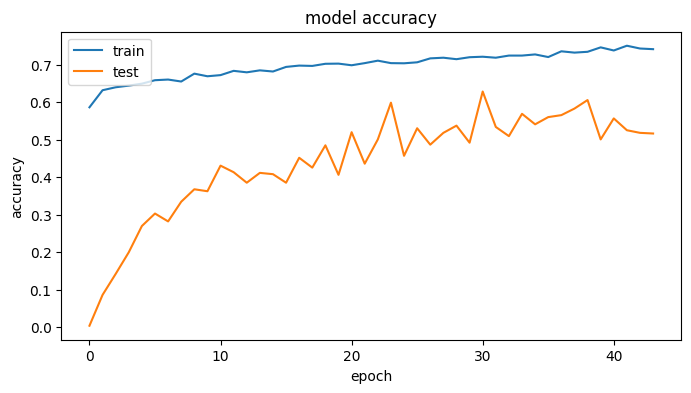

In [116]:
plot_accuracy(history9)

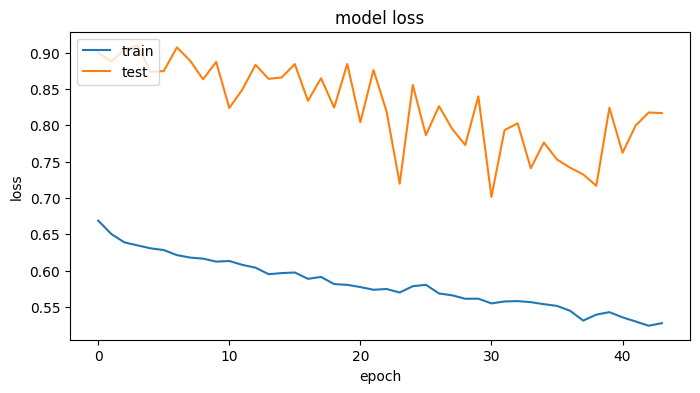

In [117]:
plot_loss(history9)

In [118]:
print(classification_report(y_val, y_pred9, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2389
           1       0.58      0.56      0.57       611

    accuracy                           0.83      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.82      0.83      0.83      3000



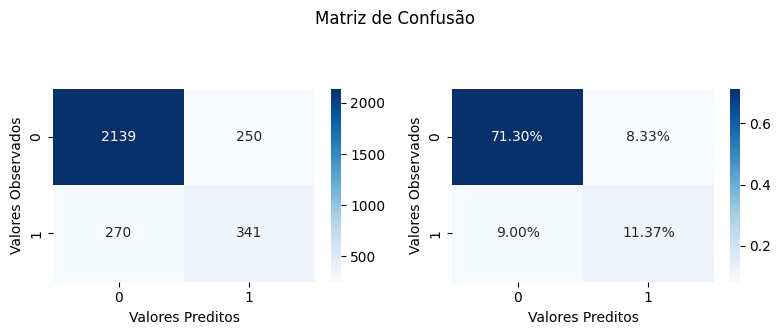

In [119]:
matriz_confusao(y_val, y_pred9)

In [120]:
f1_score_9 = round(f1_score(y_val, y_pred9), 2)
logit_roc_auc_9 = round(roc_auc_score(y_val, y_pred9), 2)
print(f'f1_score = {f1_score_9}')
print(f'roc_auc = {logit_roc_auc_9}')

f1_score = 0.57
roc_auc = 0.73


94/94 [==============================] - 0s 1ms/step


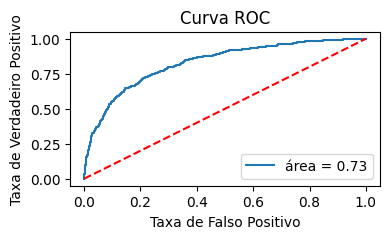

In [121]:
logit_roc_auc = roc_auc_score(y_val, y_pred9)
fpr, tpr, thresholds = roc_curve(y_val, clf9.predict(X_val))
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, label=f'área = {round(logit_roc_auc, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

A rede neural não está performando bem, conforme pode ser visto pelos gráficos apresentados.

* AutoML

In [122]:
clf10 = automl(X_train2, y_train2)

# Get predicted classes
y_pred10 = clf10.predict(X_val)

0:	learn: 0.7123170	test: 0.6606822	best: 0.6606822 (0)	total: 1.82ms	remaining: 7.3ms
1:	learn: 0.7670406	test: 0.7622378	best: 0.7622378 (1)	total: 3.64ms	remaining: 5.46ms
2:	learn: 0.7629696	test: 0.7471698	best: 0.7622378 (1)	total: 5.13ms	remaining: 3.42ms
3:	learn: 0.7773820	test: 0.7350746	best: 0.7622378 (1)	total: 6.48ms	remaining: 1.62ms
4:	learn: 0.7780239	test: 0.7276119	best: 0.7622378 (1)	total: 7.82ms	remaining: 0us

bestTest = 0.7622377622
bestIteration = 1

0:	learn: 0.7123170	test: 0.6606822	best: 0.6606822 (0)	total: 1.29ms	remaining: 5.16ms
1:	learn: 0.7299864	test: 0.7262357	best: 0.7262357 (1)	total: 2.61ms	remaining: 3.92ms
2:	learn: 0.7130518	test: 0.6798419	best: 0.7262357 (1)	total: 3.91ms	remaining: 2.61ms
3:	learn: 0.7250811	test: 0.6884615	best: 0.7262357 (1)	total: 5.24ms	remaining: 1.31ms
4:	learn: 0.7313916	test: 0.7013487	best: 0.7262357 (1)	total: 6.55ms	remaining: 0us

bestTest = 0.7262357414
bestIteration = 1

0:	learn: 0.7123170	test: 0.6606822	bes

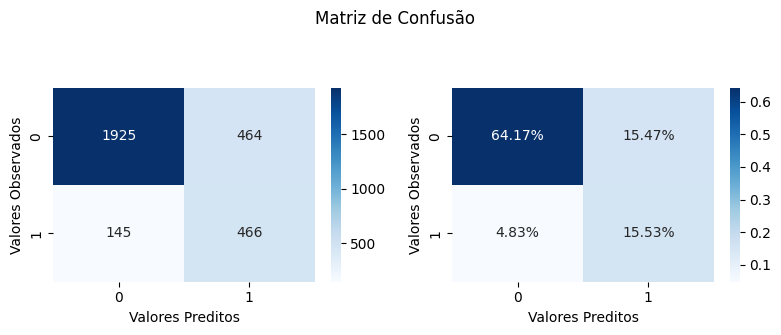

In [123]:
matriz_confusao(y_val, y_pred10)

In [124]:
f1_score_10 = round(f1_score(y_val, y_pred10), 2)
logit_roc_auc_10 = round(roc_auc_score(y_val, y_pred10), 2)
print(f'f1_score = {f1_score_10}')
print(f'roc_auc = {logit_roc_auc_10}')

f1_score = 0.6
roc_auc = 0.78


In [125]:
print(classification_report(y_val, y_pred10))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2389
           1       0.50      0.76      0.60       611

    accuracy                           0.80      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.84      0.80      0.81      3000



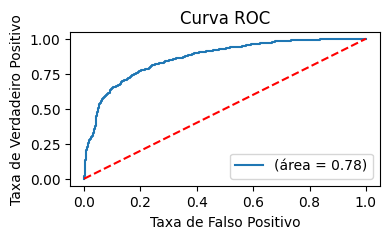

In [126]:
curva_roc(y_val, y_pred10, clf10)

Embora a quantidade de falsos negativos esteja baixa a quantidade de falsos positivos está alta, indicando que este modelo não está bom.

## Machine Learning com Dados Balanceados via Synthetic Minority Oversampling TEchnique (SMOTE)


SMOTE funciona selecionando dois pontos próximos da classe minoritária e criando uma reta ligando estes pontos, então cria um novo ponto desse classe minoritária que esteja sobre a reta.

Uma desvantagem desta técnica é que ela cria dados sintéticos sem levar em consideração a classe majoritária, fazendo com que os novos pontos criados tenham características de ambas as classes, caso as classes tenham sobreposição de pontos muito grande.

In [127]:
# criando dados sintéticos para balancear as classes y
from imblearn.over_sampling import SMOTE
X_train3, y_train3 = SMOTE().fit_resample(X_train, y_train)

* Logistic Regression

In [128]:
clf11 = logistic_regression(X_train3, y_train3)

# fazendo previsões
y_pred11 = clf11.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:

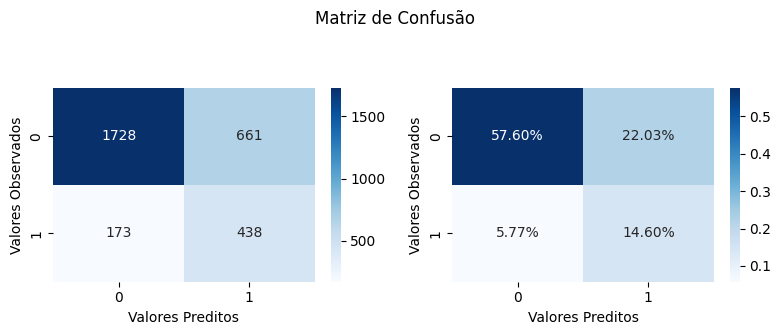

In [129]:
# criando matriz de confusão
matriz_confusao(y_val, y_pred11)

In [130]:
f1_score_11 = round(f1_score(y_val, y_pred11), 2)
logit_roc_auc_11 = round(roc_auc_score(y_val, y_pred11), 2)
print(f'f1_score = {f1_score_11}')
print(f'roc_auc = {logit_roc_auc_11}')

f1_score = 0.51
roc_auc = 0.72


In [131]:
print(classification_report(y_val, y_pred11))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2389
           1       0.40      0.72      0.51       611

    accuracy                           0.72      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.81      0.72      0.75      3000



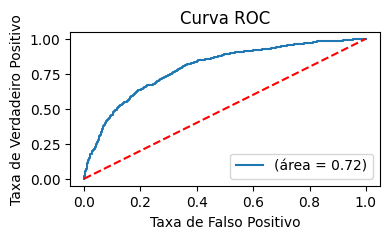

In [132]:
curva_roc(y_val, y_pred11, clf11)

Balanceamento de classes com SMOTE também parece não ter feito muita diferença para a regressão logística. Podemos olhar para a importância das variáveis para a regressão logística.

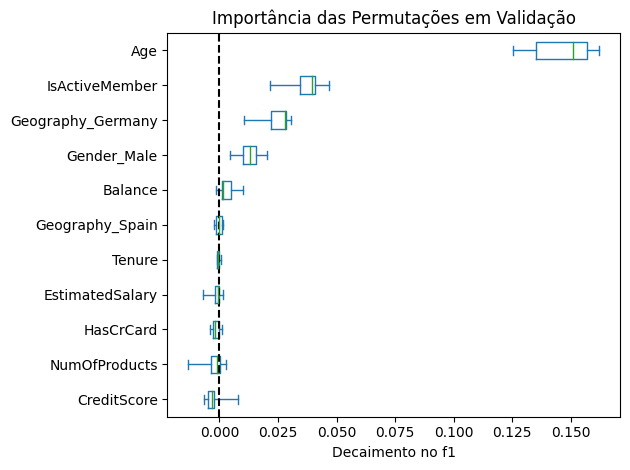

In [133]:
importancia_variaveis(clf11)

Podemos notar que as variáveis mais importantes são `Age`, `IsActiveMember` e `Geography_Germany`, todas apontadas na análise exploratória como promissoras.

* Random Forest

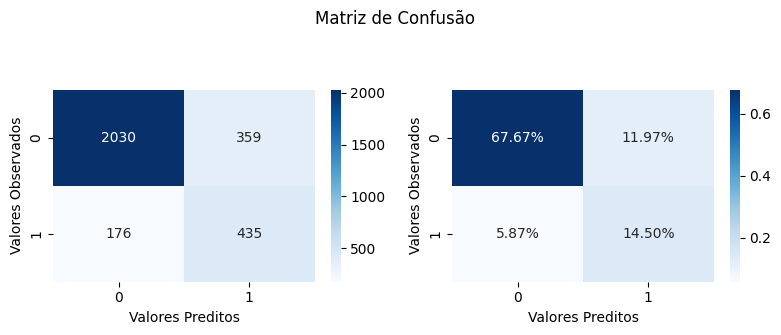

In [170]:
# treinando modelo
clf12 = random_forest(X_train3, y_train3)

# fazendo previsões
y_pred12 = clf12.predict(X_val)

# matriz de confusão
matriz_confusao(y_val, y_pred12)

In [135]:
f1_score_12 = round(f1_score(y_val, y_pred12), 2)
logit_roc_auc_12 = round(roc_auc_score(y_val, y_pred12), 2)
print(f'f1_score = {f1_score_12}')
print(f'roc_auc = {logit_roc_auc_12}')

f1_score = 0.62
roc_auc = 0.78


In [136]:
print(classification_report(y_val, y_pred12))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2389
           1       0.55      0.71      0.62       611

    accuracy                           0.82      3000
   macro avg       0.73      0.78      0.75      3000
weighted avg       0.84      0.82      0.83      3000



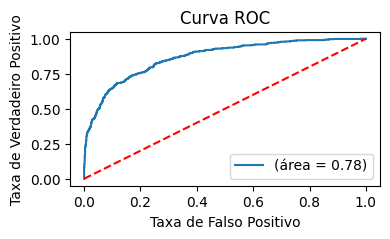

In [137]:
curva_roc(y_val, y_pred12, clf12)

Esta versão da Random Forest está bem similar à primeira versão criada. Vamos olhar para a importância das variáveis.

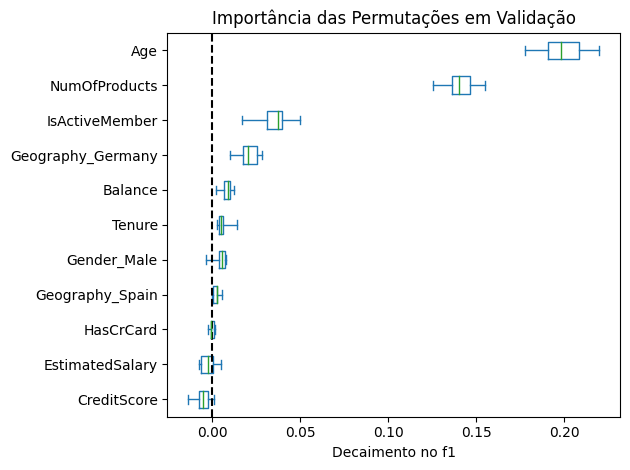

In [138]:
importancia_variaveis(clf12)

As variáveis de importância são as mesmas apontadas por outros modelos e pela análise exploratória dados, embora o valor da importância mude de um modelo para outro.

* XGBoost

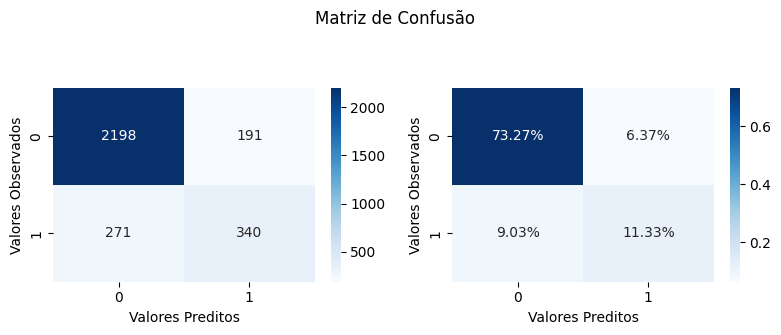

In [139]:
clf13 = meu_xgboost(X_train3, y_train3)

# fazendo previsões no conjunto de teste
y_pred13 = clf13.predict(X_val)

# criando mapa de calor
matriz_confusao(y_val, y_pred13)

In [140]:
f1_score_13 = round(f1_score(y_val, y_pred13), 2)
logit_roc_auc_13 = round(roc_auc_score(y_val, y_pred13), 2)
print(f'f1_score = {f1_score_13}')
print(f'roc_auc = {logit_roc_auc_13}')

f1_score = 0.6
roc_auc = 0.74


In [141]:
print(classification_report(y_val, y_pred13))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2389
           1       0.64      0.56      0.60       611

    accuracy                           0.85      3000
   macro avg       0.77      0.74      0.75      3000
weighted avg       0.84      0.85      0.84      3000



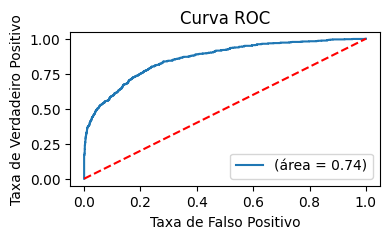

In [142]:
curva_roc(y_val, y_pred13, clf13)

Esta versão do XGBoost não conseguiu superar a versão anterior.

Vamos verificar a importância das variáveis.

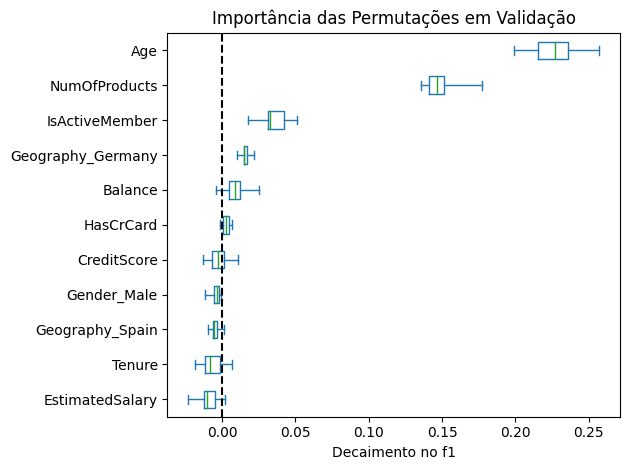

In [143]:
importancia_variaveis(clf13)

* Rede Neural

In [144]:
# Definir a função objetivo para otimização
def objective14(trial):
    # Definir os hiperparâmetros a serem otimizados
    hidden_units = trial.suggest_int('hidden_units', 2, 20)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    epochs = trial.suggest_int('epochs', 20, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.9)

    # Construir o modelo da rede neural
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=11, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train3, y_train3, epochs=epochs, verbose=0)

    # Fazer previsões nos dados de teste
    y_pred = (model.predict(X_val) >= 0.5).astype(int)

    # Calcular o f1-score
    f_score = f1_score(y_val, y_pred)

    return f_score

In [145]:
# Criar um estudo Optuna e otimizar os hiperparâmetros
study14 = optuna.create_study(direction='maximize')
study14.optimize(objective14, n_trials=15)

# Imprimir os resultados
print("Melhores Hiperparâmetros: {}".format(study14.best_trial.params))

[I 2023-06-14 04:05:25,919] A new study created in memory with name: no-name-2332f237-3c00-4f88-9e8e-eb9b52f8094d


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:06:08,340] Trial 0 finished with value: 0.5466034755134281 and parameters: {'hidden_units': 11, 'optimizer': 'rmsprop', 'epochs': 29, 'dropout_rate': 0.3705695510410014}. Best is trial 0 with value: 0.5466034755134281.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:06:50,214] Trial 1 finished with value: 0.5795454545454545 and parameters: {'hidden_units': 8, 'optimizer': 'rmsprop', 'epochs': 38, 'dropout_rate': 0.2997290734109638}. Best is trial 1 with value: 0.5795454545454545.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:07:34,037] Trial 2 finished with value: 0.5854241338112306 and parameters: {'hidden_units': 6, 'optimizer': 'rmsprop', 'epochs': 43, 'dropout_rate': 0.3401505551270608}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:08:16,134] Trial 3 finished with value: 0.5342237061769617 and parameters: {'hidden_units': 10, 'optimizer': 'adam', 'epochs': 20, 'dropout_rate': 0.8918838497077426}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:08:58,032] Trial 4 finished with value: 0.568935427574171 and parameters: {'hidden_units': 8, 'optimizer': 'rmsprop', 'epochs': 34, 'dropout_rate': 0.7986684848931358}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:09:46,628] Trial 5 finished with value: 0.5820895522388059 and parameters: {'hidden_units': 4, 'optimizer': 'adam', 'epochs': 45, 'dropout_rate': 0.19973463592534532}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:10:14,593] Trial 6 finished with value: 0.5649913344887348 and parameters: {'hidden_units': 10, 'optimizer': 'rmsprop', 'epochs': 27, 'dropout_rate': 0.5508589384314541}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:10:49,815] Trial 7 finished with value: 0.5561555075593952 and parameters: {'hidden_units': 16, 'optimizer': 'adam', 'epochs': 33, 'dropout_rate': 0.7446563968767048}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:11:31,725] Trial 8 finished with value: 0.516575952498763 and parameters: {'hidden_units': 5, 'optimizer': 'adam', 'epochs': 36, 'dropout_rate': 0.8743728042222263}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:12:05,063] Trial 9 finished with value: 0.5538461538461538 and parameters: {'hidden_units': 5, 'optimizer': 'adam', 'epochs': 31, 'dropout_rate': 0.3868959476231576}. Best is trial 2 with value: 0.5854241338112306.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:12:55,243] Trial 10 finished with value: 0.5952227243382828 and parameters: {'hidden_units': 16, 'optimizer': 'rmsprop', 'epochs': 49, 'dropout_rate': 0.1531325748790296}. Best is trial 10 with value: 0.5952227243382828.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:14:18,196] Trial 11 finished with value: 0.6190803019903912 and parameters: {'hidden_units': 18, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.11698952772229337}. Best is trial 11 with value: 0.6190803019903912.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:15:09,696] Trial 12 finished with value: 0.5938697318007663 and parameters: {'hidden_units': 20, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.10423069674968932}. Best is trial 11 with value: 0.6190803019903912.


94/94 [==============================] - 0s 1ms/step


[I 2023-06-14 04:16:08,061] Trial 13 finished with value: 0.6243016759776536 and parameters: {'hidden_units': 15, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.11158146475499414}. Best is trial 13 with value: 0.6243016759776536.


94/94 [==============================] - 0s 2ms/step


[I 2023-06-14 04:17:30,881] Trial 14 finished with value: 0.6012439530062199 and parameters: {'hidden_units': 15, 'optimizer': 'rmsprop', 'epochs': 44, 'dropout_rate': 0.21650652933994993}. Best is trial 13 with value: 0.6243016759776536.


Melhores Hiperparâmetros: {'hidden_units': 15, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.11158146475499414}


In [146]:
# treinando a rede neural com os melhores hiperparâmetros
best_params14 = study14.best_trial.params

clf14 = Sequential()
clf14.add(Dense(best_params14['hidden_units'], input_dim=11, activation='relu'))
clf14.add(Dense(best_params14['hidden_units'], activation='relu'))
clf14.add(Dropout(best_params14['dropout_rate']))
clf14.add(Dense(1, activation='sigmoid'))
clf14.compile(loss='binary_crossentropy', optimizer=best_params14['optimizer'], metrics=['accuracy'])

# callbacks
callback = EarlyStopping(monitor='loss', patience=5, verbose=False)

# Treinar o modelo com todos os dados de treinamento
history14 = clf14.fit(X_train3, y_train3,
                      epochs=best_params14['epochs'],
                      callbacks=[callback],
                      validation_split = 0.20,
                      verbose=False)

# Fazer previsões com o modelo treinado
y_pred14 = (clf14.predict(X_val) >= 0.5).astype(int)

94/94 [==============================] - 0s 1ms/step


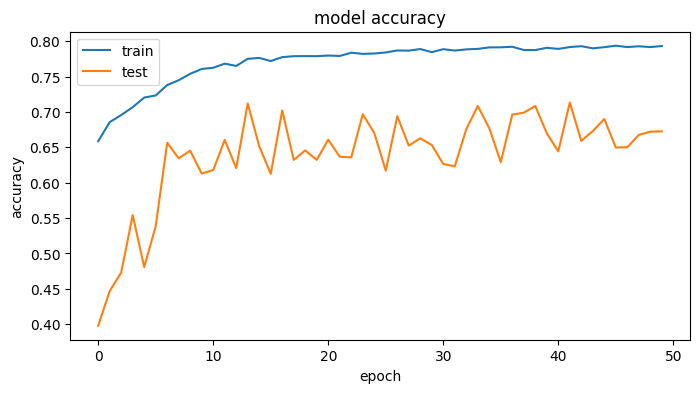

In [147]:
plot_accuracy(history14)

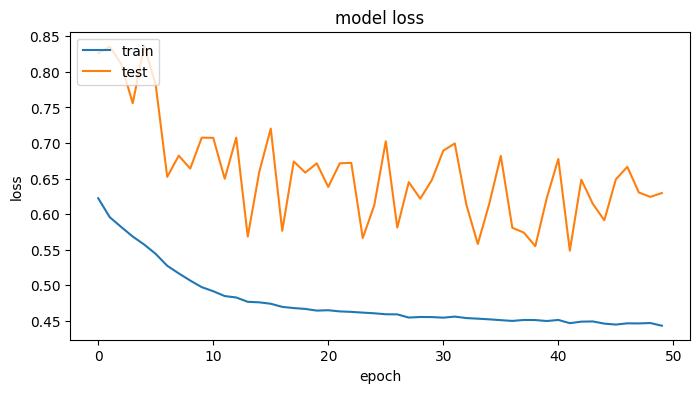

In [148]:
plot_loss(history14)

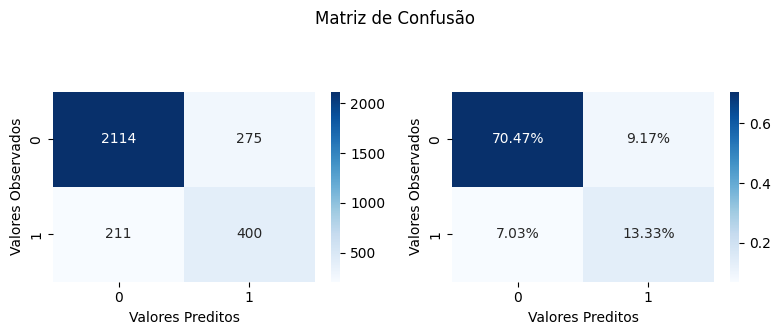

In [149]:
matriz_confusao(y_val, y_pred14)

In [150]:
f1_score_14 = round(f1_score(y_val, y_pred14), 2)
logit_roc_auc_14 = round(roc_auc_score(y_val, y_pred14), 2)
print(f'f1_score = {f1_score_14}')
print(f'roc_auc = {logit_roc_auc_14}')

f1_score = 0.62
roc_auc = 0.77


In [151]:
print(classification_report(y_val, y_pred14, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2389
           1       0.59      0.65      0.62       611

    accuracy                           0.84      3000
   macro avg       0.75      0.77      0.76      3000
weighted avg       0.84      0.84      0.84      3000



94/94 [==============================] - 0s 2ms/step


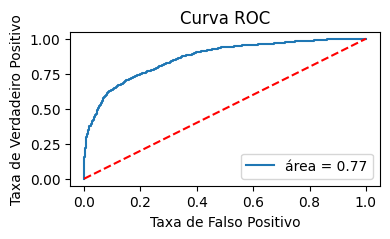

In [152]:
logit_roc_auc = roc_auc_score(y_val, y_pred14)
fpr, tpr, thresholds = roc_curve(y_val, clf14.predict(X_val))
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, label=f'área = {round(logit_roc_auc, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

Esta é a melhor versão da rede neural e está comparàvel aos melhores modelos obtidos até o momento.

### AutoML com CatBoost

In [153]:
# treinando modelo
clf15 = automl(X_train3, y_train3)

# fazendo previsões
y_pred15 = clf15.predict(X_val)

0:	learn: 0.7688191	test: 0.7885238	best: 0.7885238 (0)	total: 3.66ms	remaining: 14.7ms
1:	learn: 0.7976775	test: 0.8155683	best: 0.8155683 (1)	total: 7.12ms	remaining: 10.7ms
2:	learn: 0.7985356	test: 0.8067151	best: 0.8155683 (1)	total: 9.72ms	remaining: 6.48ms
3:	learn: 0.8102740	test: 0.8150808	best: 0.8155683 (1)	total: 12.6ms	remaining: 3.14ms
4:	learn: 0.8133180	test: 0.8172336	best: 0.8172336 (4)	total: 15.3ms	remaining: 0us

bestTest = 0.8172335601
bestIteration = 4

0:	learn: 0.7688191	test: 0.7885238	best: 0.7885238 (0)	total: 2.86ms	remaining: 11.5ms
1:	learn: 0.7686758	test: 0.7885238	best: 0.7885238 (0)	total: 5.77ms	remaining: 8.65ms
2:	learn: 0.7702038	test: 0.7880764	best: 0.7885238 (0)	total: 8.82ms	remaining: 5.88ms
3:	learn: 0.7742392	test: 0.7904360	best: 0.7904360 (3)	total: 11.4ms	remaining: 2.85ms
4:	learn: 0.7767993	test: 0.7915888	best: 0.7915888 (4)	total: 14.2ms	remaining: 0us

bestTest = 0.791588785
bestIteration = 4

0:	learn: 0.7688191	test: 0.7885238	bes

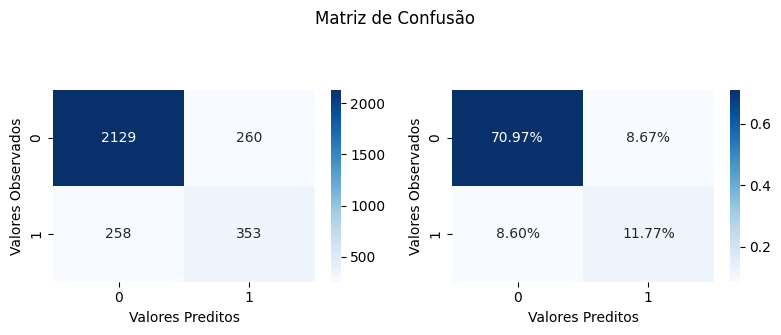

In [154]:
matriz_confusao(y_val, y_pred15)

In [155]:
f1_score_15 = round(f1_score(y_val, y_pred15), 2)
logit_roc_auc_15 = round(roc_auc_score(y_val, y_pred15), 2)
print(f'f1_score = {f1_score_15}')
print(f'roc_auc = {logit_roc_auc_15}')

f1_score = 0.58
roc_auc = 0.73


In [156]:
print(classification_report(y_val, y_pred15))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2389
           1       0.58      0.58      0.58       611

    accuracy                           0.83      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.83      0.83      0.83      3000



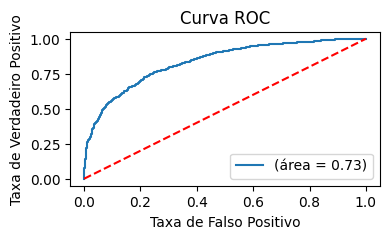

In [157]:
curva_roc(y_val, y_pred15, clf15)

Esta versão do AutoML também não se saiu muito bem.

## Seleção de Variáveis

Pelos gráficos de importância de variáveis vistos até agora podemos perceber que algumas variáveis parecem não ter relevância para os modelos, portanto podemremos selecionar apenas algumas variáveis interessante para os modelos.

Se as métricas melhorarem então teremos um ganho que justifique trabalhar com um número menor de variáveis. Se as métricas tiverem uma piora muito pequena, ainda assim, poderíamos considerar trabalhar com um número de menor de variáveis, pois isso poderia trazer outros benefícios como o tempo de previsão o que seria especialmente importante se o modelo tivesse que fazer um número extremamente grande de previsões e tivesse que ser rápido, embora não pareça ser o caso deste projeto.


Há várias técnicas de seleção de features, usaremos apenas as variáveis mais relevantes apontadas para a Random Forest, também usaremos apenas este modelo a título de ilustração.

* Seleção de Variáveis (Manual)

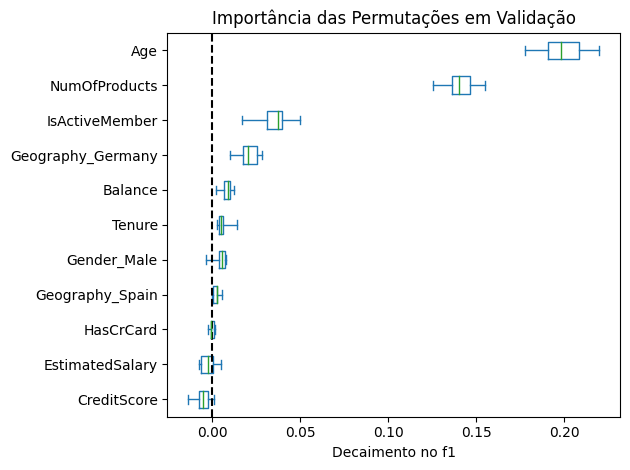

In [158]:
importancia_variaveis(clf12)

In [159]:
# variáveis relevantes
selec2 = ['Age','NumOfProducts','Geography_Germany','IsActiveMember','Balance']

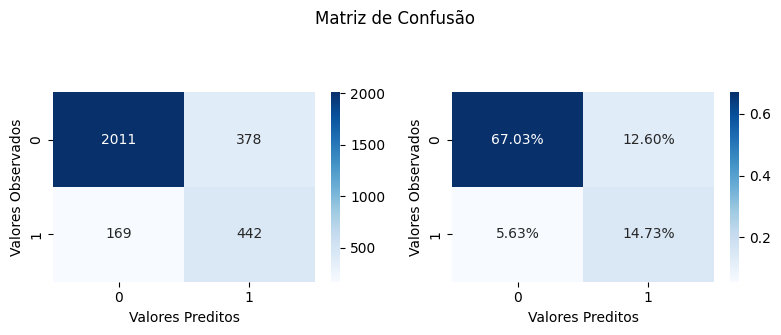

In [160]:
# treinando modelo
clf16 = random_forest(X_train3[selec2], y_train3)

# fazendo previsões
y_pred16 = clf16.predict(X_val[selec2])

# matriz de confusão
matriz_confusao(y_val, y_pred16)

In [161]:
f1_score_16 = round(f1_score(y_val, y_pred16), 2)
logit_roc_auc_16 = round(roc_auc_score(y_val, y_pred16), 2)
print(f'f1_score = {f1_score_16}')
print(f'roc_auc = {logit_roc_auc_16}')

f1_score = 0.62
roc_auc = 0.78


In [162]:
print(classification_report(y_val, y_pred16))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2389
           1       0.54      0.72      0.62       611

    accuracy                           0.82      3000
   macro avg       0.73      0.78      0.75      3000
weighted avg       0.84      0.82      0.83      3000



Podemos notar que a seleção de variáveis não piorou nossas métricas, na verdade a seleção manual parece ter melhorado levemente as métricas. Dessa forma, vale a pena manter o modelo apenas com poucas variáveis, pois isso vai levar a um menor custo computacional no pré processamento de dados para predição e ganho no tempo.

# Escolha do Melhor Modelo

Agora podemos comparar todos os modelos e todas as técnicas de pré processamento utilizadas para ver qual foi o melhor modelo obtido. Para isso vamos criar um dataframe com todas as métricas obtidas. Usaremos nesse dataframe apenas os modelos que foram treinados com todas as variáveis.

In [171]:
# lista de modelos
modelos = [clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10,clf11,clf12,clf13,clf14,clf15]

# lista das previsões de cada modelo
previsoes = [(modelos[i].predict(X_val) >= 0.5).astype(int) for i in range(0,15)]

# lista com o nome dos modelos
indices = ['clf'+str(i) for i in range(1,16)]

94/94 [==============================] - 0s 1ms/step


In [172]:
# lista com a métrica f1_score para todos os modelos
f1 = [round(f1_score(y_val, previsoes[i]), 2) for i in range(0,15)]

# lista com a métrica roc_auc_score para todos os modelos
roc_auc = [round(roc_auc_score(y_val, previsoes[i]), 2) for i in range(0,15)]

In [173]:
# criando dataframe com todas as métricas
metricas = pd.DataFrame({'f1':f1, 'roc_auc':roc_auc}, index=indices).transpose()
metricas

,clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10,clf11,clf12,clf13,clf14,clf15
f1,0.51,0.62,0.60,0.57,0.60,0.51,0.61,0.60,0.57,0.60,0.51,0.62,0.60,0.62,0.58
roc_auc,0.72,0.78,0.73,0.71,0.73,0.72,0.79,0.78,0.73,0.78,0.72,0.78,0.74,0.77,0.73


Podemos notar que os melhores modelos tiveram valor de `f1_score` ligeiramente acima de 0.60 e valor de área sob a curva roc acima de 0.70.

Temos dois modelos nessa faixa de valores para os dados desbalanceados, nenhum com undersampling e três com SMOTE. Desta maneira, vamos considerar que a melhor maneira de proceder é com a técnica de balanceamento via SMOTE.


Levando isso em conta, os melhores modelos (todos com métricas semelhantes) são Random Forest, XGBoost e Rede Neural. Embora todos praticamente empatem no `f1_score` o Random Forest apresenta maior área sob a curva ROC. Além disso, o Random Forest apresenta menos falsos negativos que os demais, mantendo relativamente poucos falsos positivos.


Com base nisso poderíamos considerar que apesar das métricas semelhantes a Random Forest foi melhor, pois estamos mais preocupados com os clientes que deixariam o banco sem que o modelo os identificasse (falsos negativos).

# Entendendo o Modelo

Agora usaremos algumas técnicas de Explainable Artificial Intelligence (XAI) para obter um melhor entendimento do melhor modelo obtido treinado com todas as variáveis, que foi o Random Forest com dados balanceados com a técnica SMOTE. Usaremos esse modelo pois ele tem mais variáveis e permite uma análise mais "rica", embora pudessemos utilizar o modelo com menos variáveis.

Usaremos a biblioteca `SHAP`. Esta biblioteca usa o conceito de valores de SHAP da Teoria dos Jogos para calcular a importância das variáveis.

In [174]:
# instalando a biblioteca shap
!pip install shap -q

# importando a biblioteca
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 18.6 MB/s eta 0:00:00


In [175]:
# calculando SHAP values
explainer = shap.TreeExplainer(clf12)
shap_values = explainer.shap_values(X_val)

Podemos obter um gráfico que mostra a importância das variáveis e o quanto cada uma influencia o modelo para decidir pela classe 0 ou pela classe 1. Este é um gráfico para auxiliar na interpretabilidade global do modelo.

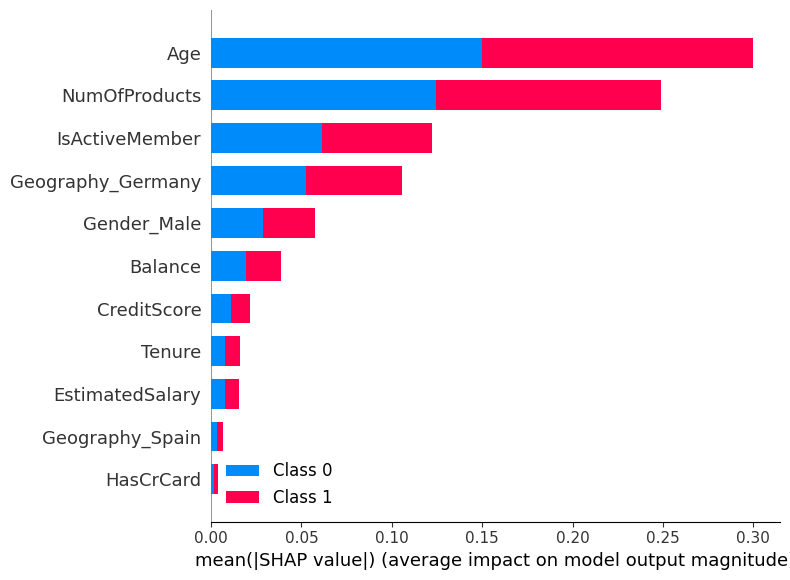

In [176]:
# summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

Podemos notar que a importância calculada com os valores de SHAP são praticamente as mesmas que calculadas de outra forma e para outros modelos.

Podemos também usar a função `summary_plot()` para ter um entendimento do efeito das variáveis nas predições, se influenciam para que seja tomada uma decisão com relação à classe 0 ou à classe 1.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


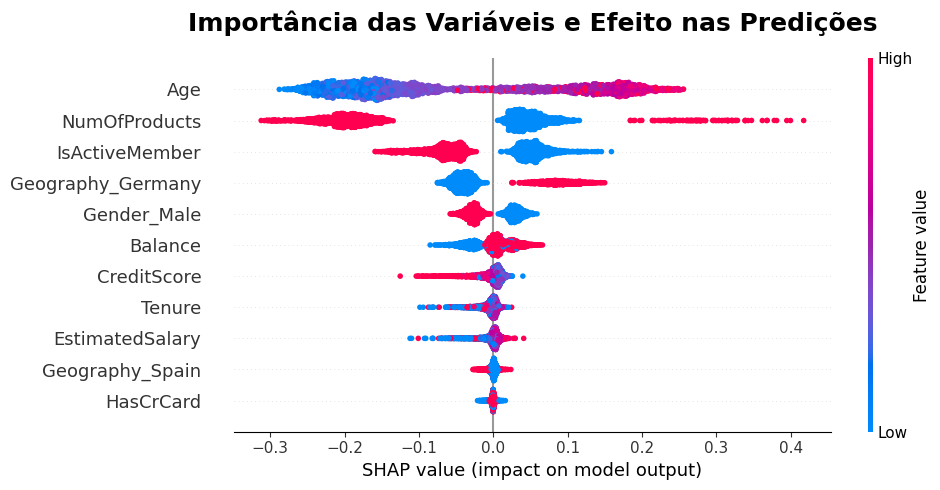

In [177]:
plt.title("Importância das Variáveis e Efeito nas Predições", fontweight="black", pad=20, size=18)
shap.summary_plot(shap_values[1], X_val.values, feature_names = X_val.columns, plot_size=(10,5))

A cor vermelha representa valores que contribuem para um aumento do valor predito. A cor azul representa valores que contribuem para uma diminuição do valores predito.


Desta forma, podemos notar que:

1) pessoas com idade maior tendem a sair do banco. Essa informação já apareceu na análise exploratória, em que a distribuição dos indivíduos que deixarm o banco estava centrada mais a direita do que a distribuição dos indivíduos que permaneciam no banco;

2) pessoas com `IsActiveMember=0` tendem a permanecer no banco e `IsActiveMember=1` tendem a sair;

3) pessoas da Germany são mais propensas a deixar o banco;

4) pessoas com `Gender_Male=0` (mulheres) tendem a sair no banco;

5) pessoas com `Balance=1` (positivo) tendem a sair no banco;

6) pessoas com `CreditScore` baixo tendem a deixar o banco.


Boa parte desses insights foram obtidos na análise exploratória e, de certa forma, confirmados pela análise do modelo.


Essa análise permite maior interpretabilidade do modelo, permitindo entender como ele classifica os clientes.

Também podemos usar essa biblioteca para ter uma ideia da interpretabilidade local, isto é, de como o modelo tomou a decisão para cada indivíduo. Para tanto usaremos a função `force_plot()`. Vamos ver a classificação do modelo e a probabilidade com que faz a classificação e, depois vamos usar o `force_plot()` para entender o peso de cada variável nesse cálculo de probabilidade.

In [178]:
print(f'A primeira observação é da classe {clf12.predict(X_val.iloc[:1,:])[0]}')
print(f'A classificação foi feita com {clf12.predict_proba(X_val.iloc[:1,:])[0][0]} % de probabilidade')

A primeira observação é da classe 0
A classificação foi feita com 0.9558667913899029 % de probabilidade


In [179]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_val.iloc[0,:])

Podemos notar que para a primeira observação dos dados de validação o modelo classifica com 96% de probabilidade e podemos que essa decisão foi tomadas com base em todas as variáveis e o peso de cada uma nessa decisão. Por exemplo, a variável `NumOfProducts` foi a que teve maior contribuição.

O `CreditScore` está alto, o `Balance` é nulo, não é da Germany, é uma pessoa do sexo masculino e jovem. Todas tendências apontadas como de pessoas que permaneceriam no banco.

Agora vamos analisar outra observação.

In [180]:
print(f'A segunda observação é da classe {clf12.predict(X_val.iloc[1:2,:])[0]}')
print(f'A classificação foi feita com {clf12.predict_proba(X_val.iloc[1:2,:])[0][0]} % de probabilidade')

A segunda observação é da classe 0
A classificação foi feita com 0.7170308235984356 % de probabilidade


In [181]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X_val.iloc[1,:])

Desta vez podemos notar que o modelo está fazendo a classificação com "apenas" 72% de probabilide pois algumas variáveis (em azul) não estão colaborando para a tomada da mesma decisão como as variáveis em vermelho.

# Salvando o Modelo Treinado

Agora que temos um melhor modelo, vamos trainá-lo com todo o conjunto de dados (treino e validação) para fornecer mais informações para o melhor classificador encontrado e, então poderemos usar para fazer previsões no conjunto de teste.

Também vamos salvar este modelo para que ele possa ser disponibilizado em produção, mas antes precisaremos tratar os dados de teste da mesma forma que fizemos com os dados de treino.

In [199]:
teste = pd.read_csv('/content/Abandono_teste.csv', sep=';')
teste.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


Quando o modelo está em produção precisará ser usado várias vezes, logo será necessário pré processar os dados antes de fazer as previsões. Por isso, faremos uma função para facilitar esse procedimento.

Neste projeto usamos o `MinMaxScaler` para escalonar os dados, mas os valores aprendidos foram os do conjunto de teste, então é uma boa prática salvar o `scaler` treinado e importar quando necessário para preparar novos dados e é isso que faremos a seguir.

Usaremos a biblioteca `pickle` para salvar o scaler e o modelo treinado.

In [183]:
# importando biblioteca
import pickle

In [184]:
# salvando modelo treinado
pickle.dump(clf16, open('random_forest_16.sav', 'wb'))

# salvando o scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [201]:
# função para pré processamento
def preprocessamento_dados(df):
    # importando biblioteca para carregar o scaler treinado
    import pickle

    # carregando o scaler
    scaler = pickle.load(open('scaler.pkl', 'rb'))

    RowNumber = df['RowNumber']

    # descartando colunas irrelevantes
    df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

    # alterando coluna Balance
    df['Balance'] = [1 if x > 0 else 0 for x in df['Balance']]

    # OneHotEncoding
    df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)

    # escalonando os dados
    df = pd.DataFrame(scaler.transform(df), columns=colunas)

    # selecionando apenas colunas de interesse
    df = df[selec2]

    return df, RowNumber

In [202]:
# pre processando os dados
teste2, RowNumber = preprocessamento_dados(teste)

# importando o modelo treinado
clf = pickle.load(open('random_forest_16.sav', 'rb'))

# fazendo previsoes
predictedValues = clf.predict(teste2)

previsoes = pd.DataFrame({'RowNumber':RowNumber,
                            'predictedValues':predictedValues})

In [206]:
# salvando as previsoes em arquivo csv e fazendo download
from google.colab import files
previsoes.to_csv('previsoes.csv', index=False)
files.download("previsoes.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>